In [1]:
import numpy as np
import os
import sqlalchemy
import pandas as pd
import geopandas as gpd
from refit_fvs.data.calculate_mai import calc_mai

from matplotlib import pyplot as plt

# Checking on Available Trees for Modeling Diameter Growth and Mortality
In this notebook, we inspect the data available from the FIA databases of Washington, Oregon, and California. Our goal is to identify how many remeasured trees are available for modeling diameter growth and mortality and summarizing these samples by tree species, size, crown position, geographic location, etc. We are also particularly concerned about identifying and excluding remeasured plots where measurement errors may have been documented or appear to have been made. We focus on identifying trees that were not recorded in the previous visit to the plot to indicate a measurement issue.

In [2]:
# we have three separate databases, one for each state
DATA_DIR = "../../data/"
ORDB = "raw/FIADB_OR.db"
WADB = "raw/FIADB_WA.db"
CADB = "raw/FIADB_CA.db"
ORengine = sqlalchemy.create_engine(f"sqlite:///{DATA_DIR + ORDB}")
WAengine = sqlalchemy.create_engine(f"sqlite:///{DATA_DIR + WADB}")
CAengine = sqlalchemy.create_engine(f"sqlite:///{DATA_DIR + CADB}")

## FIA Plot Layout
Each FIA "plot" is measured through the use of four "subplots". Each "subplot" is measured using multiple fixed radius sampling areas for different trees (microplots, subplots, and macroplots). We will identify all the plots in the FIA database that have been measured more than once (remeasurement occurs on a ~10-year cycle). More detailed documentation on the FIA Database [can be found here](https://www.fia.fs.fed.us/library/database-documentation/current/ver90/FIADB%20User%20Guide%20P2_9-0-1_final.pdf).

![FIA Plot Layout](../../reports/figures/fia_plot_design.png)

## Collecting Conditions, Plots, and Trees
We are ultimately working towards the development of an dataset ready for growth-and-yield modeling that treats aggregates all trees measured on each subplot (or macroplot) as the largest unit of analysis. This is slightly different from the two primary options offered by the FVS-ready FIA data (which summarize FIA data either by condition or by plot). 

We will filter observations in the California, Oregon, and Washington FIA databases to exclude plots where human, fire, or geologic disturbances have occurred since the last time a location was measured. This filtering will involve working with the data at three levels: plots, conditions, and trees. Each plot is a combination of multiple subplots. Distinct forested "conditions" are mapped across subplots as illustrated below: 

<div><img src="../../reports/figures/fia_plot_conditions.png" width="400"/></div>

To filter plots to arrive at the dataset we want to use for growth-and-yield modeling we need to:
1. Select plots where trees have been observed that have been remeasured. Many plots are established in non-forest areas, and not all plots have yet been remeasured.
2. Identify *conditions* where a human, fire, or geologic disturbance is recorded since the previous field visit. These disturbances are recorded for each *condition* using the DSTRBCD and TRTCD fields in the COND table. An FIA plot that contains any condition which has been subjected to any of these disturbances will be filtered out. 
3. Identify trees that have been cut since the previous field visit. Many plots contain observations of cut trees that are not also recorded as having had a human disturbance in either the TRTCD or DSTRBCD fields. We will filter out an FIA plot that has any cut trees observed on it.

# Step 1: Identifying plots with trees that have been remeasured.
To do this filter, we will need to retrieve plot and tree records. We will identify plots where the plot-level control number (PLOT_CN) and the control number from the previous observation of a plot (PLOT_CN_PREV) also exists in the TREE table. 

In [3]:
SQL = """
SELECT PLOT.STATECD, PLOT.UNITCD, PLOT.COUNTYCD, PLOT.PLOT,
       PLOT.STATECD * 100 * 1000 * 100000 + PLOT.UNITCD * 1000 * 100000 
       + PLOT.COUNTYCD * 100000 + PLOT.PLOT AS PLOT_ID,
       PLOT.CN AS PLOT_CN, PREV_PLT_CN AS PLOT_CN_PREV,
       MEASYEAR, MEASMON, MEASDAY, REMPER, DESIGNCD,
       LAT, LON, ELEV, TOPO_POSITION_PNW,
       FVS_STANDINIT_PLOT.VARIANT, FVS_STANDINIT_PLOT.LOCATION,
       FVS_STANDINIT_PLOT.SLOPE, FVS_STANDINIT_PLOT.ASPECT, 
       FVS_STANDINIT_PLOT.FOREST_TYPE_FIA AS FORTYPCD, 
       REF_FOREST_TYPE.MEANING AS FORTYPNM,
       REF_FOREST_TYPE_GROUP.MEANING AS FORTYPGRP,
       FVS_STANDINIT_PLOT.SITE_INDEX AS SICOND, 
       FVS_STANDINIT_PLOT.SITE_INDEX_BASE_AG AS SIBASE, 
       FVS_STANDINIT_PLOT.SITE_SPECIES AS SISP 
FROM PLOT
LEFT JOIN FVS_STANDINIT_PLOT
ON PLOT.CN = STAND_CN
LEFT JOIN REF_FOREST_TYPE
ON FVS_STANDINIT_PLOT.FOREST_TYPE_FIA = REF_FOREST_TYPE.VALUE
LEFT JOIN REF_FOREST_TYPE_GROUP
ON REF_FOREST_TYPE.TYPGRPCD = REF_FOREST_TYPE_GROUP.VALUE
ORDER BY STATECD, UNITCD, COUNTYCD, PLOT, MEASYEAR
"""
plots = pd.concat(
    [
        pd.read_sql(SQL, ORengine),
        pd.read_sql(SQL, WAengine),
        pd.read_sql(SQL, CAengine),
    ],
    axis=0,
    ignore_index=True,
)
plots.loc[pd.isnull(plots.FORTYPNM), "FORTYPNM"] = "NONE"
plots.loc[pd.isnull(plots.FORTYPGRP), "FORTYPGRP"] = "NONE"
plots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94231 entries, 0 to 94230
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   STATECD            94231 non-null  int64  
 1   UNITCD             94231 non-null  int64  
 2   COUNTYCD           94231 non-null  int64  
 3   PLOT               94231 non-null  int64  
 4   PLOT_ID            94231 non-null  int64  
 5   PLOT_CN            94231 non-null  object 
 6   PLOT_CN_PREV       39653 non-null  object 
 7   MEASYEAR           94231 non-null  int64  
 8   MEASMON            94205 non-null  float64
 9   MEASDAY            94205 non-null  float64
 10  REMPER             39466 non-null  float64
 11  DESIGNCD           94231 non-null  int64  
 12  LAT                93787 non-null  float64
 13  LON                93787 non-null  float64
 14  ELEV               87721 non-null  float64
 15  TOPO_POSITION_PNW  42006 non-null  object 
 16  VARIANT            772

In [4]:
SQL = """
SELECT PLOT.STATECD, PLOT.UNITCD, PLOT.COUNTYCD, PLOT.PLOT, SUBPLOT.SUBP AS SUBPLOT, 
       TREE.CONDID, PLOT.STATECD * 100 * 1000 * 100000 + PLOT.UNITCD * 1000 * 100000 
       + PLOT.COUNTYCD * 100000 + PLOT.PLOT AS PLOT_ID, 
       10 * (PLOT.STATECD * 100 * 1000 * 100000 + PLOT.UNITCD * 1000 * 100000 
       + PLOT.COUNTYCD * 100000 + PLOT.PLOT) + SUBPLOT.SUBP AS SUBPLOT_ID,
       PLOT.CN AS PLOT_CN, PLOT.PREV_PLT_CN AS PLOT_CN_PREV, 
       SUBPLOT.CN AS SUBPLOT_CN, SUBPLOT.PREV_SBP_CN AS SUBPLOT_CN_PREV,
       TREE.CN AS TREE_CN, TREE.PREV_TRE_CN AS TREE_CN_PREV, TREE.TREE AS TREE_ID, 
       PLOT.MEASYEAR AS INVYR, FVS_TREEINIT_PLOT.AZIMUTH, FVS_TREEINIT_PLOT.DISTANCE,
       TREE.STATUSCD, TREE.RECONCILECD,
       TREE.SPCD AS SPECIES, REF_SPECIES.COMMON_NAME, TREE.TPA_UNADJ,
       TREE.DIA AS DBH, TREE.PREVDIA AS DBH_PREV, 
       TREE.HT, TREE.ACTUALHT, TREE.CR, TREE.CCLCD, TREE.MORTYR,
       TREE.INC10YR_PNWRS AS INC10YR, TREE.INC5YR_PNWRS AS INC5YR
FROM TREE
LEFT JOIN FVS_TREEINIT_PLOT
ON TREE.CN = FVS_TREEINIT_PLOT.TREE_CN
LEFT JOIN PLOT
ON TREE.PLT_CN = PLOT.CN
LEFT JOIN SUBPLOT 
ON PLOT.CN = SUBPLOT.PLT_CN AND TREE.SUBP = SUBPLOT.SUBP
LEFT JOIN REF_SPECIES
ON TREE.SPCD = REF_SPECIES.SPCD
ORDER BY PLOT.STATECD, PLOT.UNITCD, PLOT.COUNTYCD, PLOT.PLOT, TREE.TREE, PLOT.MEASYEAR
"""
raw_trees = pd.concat(
    [
        pd.read_sql(SQL, ORengine),
        pd.read_sql(SQL, WAengine),
        pd.read_sql(SQL, CAengine),
    ],
    axis=0,
    ignore_index=True,
)
raw_trees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503659 entries, 0 to 1503658
Data columns (total 32 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   STATECD          1503659 non-null  int64  
 1   UNITCD           1503659 non-null  int64  
 2   COUNTYCD         1503659 non-null  int64  
 3   PLOT             1503659 non-null  int64  
 4   SUBPLOT          1503657 non-null  float64
 5   CONDID           1503659 non-null  int64  
 6   PLOT_ID          1503659 non-null  int64  
 7   SUBPLOT_ID       1503657 non-null  float64
 8   PLOT_CN          1503659 non-null  object 
 9   PLOT_CN_PREV     760876 non-null   object 
 10  SUBPLOT_CN       1503657 non-null  object 
 11  SUBPLOT_CN_PREV  23239 non-null    object 
 12  TREE_CN          1503659 non-null  object 
 13  TREE_CN_PREV     645985 non-null   object 
 14  TREE_ID          1503659 non-null  int64  
 15  INVYR            1503659 non-null  int64  
 16  AZIMUTH          1

In [5]:
SQL = """
SELECT PLOT.STATECD, PLOT.UNITCD, PLOT.COUNTYCD, PLOT.PLOT, 
       SUBPLOT.SUBP AS SUBPLOT, SEEDLING.CONDID,
       PLOT.STATECD * 100 * 1000 * 100000 + PLOT.UNITCD * 1000 * 100000 
       + PLOT.COUNTYCD * 100000 + PLOT.PLOT AS PLOT_ID,
       10 * (PLOT.STATECD * 100 * 1000 * 100000 + PLOT.UNITCD * 1000 * 100000 
       + PLOT.COUNTYCD * 100000 + PLOT.PLOT) + SUBPLOT.SUBP AS SUBPLOT_ID,
       PLOT.CN AS PLOT_CN, PLOT.PREV_PLT_CN AS PLOT_CN_PREV, 
       SUBPLOT.CN AS SUBPLOT_CN, SUBPLOT.PREV_SBP_CN AS SUBPLOT_CN_PREV,
       SEEDLING.CN AS TREE_CN, NULL AS TREE_CN_PREV, NULL AS TREE_ID, 
       PLOT.MEASYEAR AS INVYR, NULL AS AZIMUTH, NULL AS DISTANCE,
       1 AS STATUSCD, NULL AS RECONCILECD,
       SEEDLING.SPCD AS SPECIES, REF_SPECIES.COMMON_NAME, SEEDLING.TPA_UNADJ,
       0.1 AS DBH, NULL AS DBH_PREV, 
       NULL AS HT, NULL AS ACTUALHT, NULL AS CR, NULL AS CCLCD, NULL AS MORTYR
FROM SEEDLING
LEFT JOIN PLOT
ON SEEDLING.PLT_CN = PLOT.CN
LEFT JOIN SUBPLOT 
ON PLOT.CN = SUBPLOT.PLT_CN AND SEEDLING.SUBP = SUBPLOT.SUBP
LEFT JOIN REF_SPECIES
ON SEEDLING.SPCD = REF_SPECIES.SPCD
ORDER BY PLOT.STATECD, PLOT.UNITCD, PLOT.COUNTYCD, PLOT.PLOT
"""
seeds = pd.concat(
    [
        pd.read_sql(SQL, ORengine),
        pd.read_sql(SQL, WAengine),
        pd.read_sql(SQL, CAengine),
    ],
    axis=0,
    ignore_index=True,
)
seeds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108977 entries, 0 to 108976
Data columns (total 30 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   STATECD          108977 non-null  int64  
 1   UNITCD           108977 non-null  int64  
 2   COUNTYCD         108977 non-null  int64  
 3   PLOT             108977 non-null  int64  
 4   SUBPLOT          108977 non-null  int64  
 5   CONDID           108977 non-null  int64  
 6   PLOT_ID          108977 non-null  int64  
 7   SUBPLOT_ID       108977 non-null  int64  
 8   PLOT_CN          108977 non-null  object 
 9   PLOT_CN_PREV     50499 non-null   object 
 10  SUBPLOT_CN       108977 non-null  object 
 11  SUBPLOT_CN_PREV  1752 non-null    object 
 12  TREE_CN          108977 non-null  object 
 13  TREE_CN_PREV     0 non-null       object 
 14  TREE_ID          0 non-null       object 
 15  INVYR            108977 non-null  int64  
 16  AZIMUTH          0 non-null       obje

In [6]:
trees = (
    pd.concat([raw_trees, seeds])
    .sort_values(
        by=["STATECD", "UNITCD", "COUNTYCD", "PLOT", "SUBPLOT", "TREE_ID", "INVYR"]
    )
    .reset_index(drop=True)
)
INT_COLS = [
    "STATECD",
    "UNITCD",
    "COUNTYCD",
    "PLOT",
    "SUBPLOT",
    "CONDID",
    "INVYR",
    "SPECIES",
    "STATUSCD",
    "RECONCILECD",
    "CCLCD",
]
trees[INT_COLS] = trees[INT_COLS].astype("Int64")
trees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1612636 entries, 0 to 1612635
Data columns (total 32 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   STATECD          1612636 non-null  Int64  
 1   UNITCD           1612636 non-null  Int64  
 2   COUNTYCD         1612636 non-null  Int64  
 3   PLOT             1612636 non-null  Int64  
 4   SUBPLOT          1612634 non-null  Int64  
 5   CONDID           1612636 non-null  Int64  
 6   PLOT_ID          1612636 non-null  int64  
 7   SUBPLOT_ID       1612634 non-null  float64
 8   PLOT_CN          1612636 non-null  object 
 9   PLOT_CN_PREV     811375 non-null   object 
 10  SUBPLOT_CN       1612634 non-null  object 
 11  SUBPLOT_CN_PREV  24991 non-null    object 
 12  TREE_CN          1612636 non-null  object 
 13  TREE_CN_PREV     645985 non-null   object 
 14  TREE_ID          1503659 non-null  object 
 15  INVYR            1612636 non-null  Int64  
 16  AZIMUTH          1

In [7]:
trees.loc[trees.TPA_UNADJ.isna()].groupby(by=["STATUSCD"])["TREE_CN"].count()

STATUSCD
0    30860
1      373
2    63140
3    20499
Name: TREE_CN, dtype: int64

In [8]:
err_trees = (
    trees.loc[trees.STATUSCD == 0]
    .groupby(by=["PLOT_CN", "SUBPLOT"])["TREE_CN"]
    .count()
    .to_frame()
    .rename({"TREE_CN": "ERRORS"}, axis=1)
)
all_trees = (
    trees.groupby(by=["PLOT_CN", "SUBPLOT"])["TREE_CN"]
    .count()
    .to_frame()
    .rename({"TREE_CN": "ALL_TREES"}, axis=1)
)
error_rate = (
    pd.concat([err_trees, all_trees], axis=1, ignore_index=False).dropna().astype(int)
)
error_plots = error_rate.loc[
    error_rate.ERRORS == error_rate.ALL_TREES
].index.get_level_values(0)

In [9]:
trees["BAPALIVE"] = (
    (0.005454 * trees.DBH**2) * (trees.STATUSCD == 1) * trees.TPA_UNADJ
)
subplot_bapa = trees.groupby(by=["SUBPLOT_ID"])["BAPALIVE"].sum()
hasliveba = subplot_bapa.loc[subplot_bapa > 0].index.values
trees = trees.loc[trees.SUBPLOT_ID.isin(hasliveba)]
trees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 774075 entries, 0 to 1612635
Data columns (total 33 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   STATECD          774075 non-null  Int64  
 1   UNITCD           774075 non-null  Int64  
 2   COUNTYCD         774075 non-null  Int64  
 3   PLOT             774075 non-null  Int64  
 4   SUBPLOT          774075 non-null  Int64  
 5   CONDID           774075 non-null  Int64  
 6   PLOT_ID          774075 non-null  int64  
 7   SUBPLOT_ID       774075 non-null  float64
 8   PLOT_CN          774075 non-null  object 
 9   PLOT_CN_PREV     334934 non-null  object 
 10  SUBPLOT_CN       774075 non-null  object 
 11  SUBPLOT_CN_PREV  8152 non-null    object 
 12  TREE_CN          774075 non-null  object 
 13  TREE_CN_PREV     244548 non-null  object 
 14  TREE_ID          713041 non-null  object 
 15  INVYR            774075 non-null  Int64  
 16  AZIMUTH          619184 non-null  flo

In [10]:
plots_with_trees = plots.loc[plots.PLOT_CN.isin(trees.PLOT_CN)].copy()
plots_with_good_trees = plots_with_trees.loc[
    ~plots_with_trees.PLOT_CN.isin(error_plots)
].copy()
remeasured_plots = (
    plots_with_good_trees.loc[plots_with_good_trees.PLOT_CN_PREV.isin(trees.PLOT_CN)]
    .copy()
    .set_index("PLOT_CN")
)
len(plots), len(plots_with_trees), len(plots_with_good_trees), len(remeasured_plots)

(94231, 37709, 37321, 14076)

In [11]:
remeasured_plots.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14076 entries, 558628150126144 to 484817756489998
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   STATECD            14076 non-null  int64  
 1   UNITCD             14076 non-null  int64  
 2   COUNTYCD           14076 non-null  int64  
 3   PLOT               14076 non-null  int64  
 4   PLOT_ID            14076 non-null  int64  
 5   PLOT_CN_PREV       14076 non-null  object 
 6   MEASYEAR           14076 non-null  int64  
 7   MEASMON            14076 non-null  float64
 8   MEASDAY            14076 non-null  float64
 9   REMPER             14076 non-null  float64
 10  DESIGNCD           14076 non-null  int64  
 11  LAT                14076 non-null  float64
 12  LON                14076 non-null  float64
 13  ELEV               14076 non-null  float64
 14  TOPO_POSITION_PNW  14063 non-null  object 
 15  VARIANT            14019 non-null  object 
 16  LOC

# Step 2: Identifying conditions with human, fire, or geologic disturbances

In [12]:
# identifying disturbed conditions
SQL = """
SELECT STATECD, UNITCD, COUNTYCD, PLOT, CONDID,
       PLT_CN AS PLOT_CN,
       STATECD * 100 * 1000 * 100000 + UNITCD * 1000 * 100000 
       + COUNTYCD * 100000 + PLOT AS PLOT_ID,
       CN AS COND_CN, INVYR,
       CONDPROP_UNADJ, FORTYPCD,
       SISP, SICOND, SIBASE, SITECLCD, VOL_LOC_GRP, PLANT_STOCKABILITY_FACTOR_PNW,
       SLOPE, ASPECT, PHYSCLCD,
       DSTRBCD1, DSTRBCD2, DSTRBCD3, 
       TRTCD1, TRTCD2, TRTCD3
FROM COND
ORDER BY PLOT_CN ASC, CONDPROP_UNADJ DESC
"""
conds = pd.concat(
    [
        pd.read_sql(SQL, ORengine),
        pd.read_sql(SQL, WAengine),
        pd.read_sql(SQL, CAengine),
    ],
    axis=0,
    ignore_index=True,
)
conds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120208 entries, 0 to 120207
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   STATECD                        120208 non-null  int64  
 1   UNITCD                         120208 non-null  int64  
 2   COUNTYCD                       120208 non-null  int64  
 3   PLOT                           120208 non-null  int64  
 4   CONDID                         120208 non-null  int64  
 5   PLOT_CN                        120208 non-null  object 
 6   PLOT_ID                        120208 non-null  int64  
 7   COND_CN                        120208 non-null  object 
 8   INVYR                          120208 non-null  int64  
 9   CONDPROP_UNADJ                 120208 non-null  float64
 10  FORTYPCD                       54829 non-null   float64
 11  SISP                           45988 non-null   float64
 12  SICOND                        

In [13]:
disturbance_codes = pd.DataFrame(
    [
        (0, "No visible disturbance"),
        (10, "Insect damage"),
        (11, "Insect damage to understory vegetation"),
        (12, "Insect damage to trees, including seedlings and saplings"),
        (20, "Disease damage"),
        (21, "Disease damage to understory vegetation"),
        (22, "Disease damage to trees, including seedlings and saplings"),
        (30, "Fire damage (from crown and ground fire, either prescribed or natural)"),
        (31, "Ground fire damage"),
        (32, "Crown fire damage"),
        (40, "Animal damage"),
        (41, "Beaver (includes flooding caused by beaver)"),
        (42, "Porcupine"),
        (43, "Deer/ungulate"),
        (44, "Bear (core optional)"),
        (45, "Rabbit (core optional)"),
        (46, "Domestic animal/livestock (includes grazing)"),
        (50, "Weather damage"),
        (51, "Ice"),
        (52, "Wind (includes hurricane, tornado)"),
        (53, "Flooding (weather induced)"),
        (54, "Drought"),
        (60, "Vegetation (suppression, competition, vines)"),
        (70, "Unknown / not sure / other"),
        (
            80,
            "Human-induced damage - any significant threshold of human-caused damage not described in the DISTURBANCE codes or in the TREATMENT codes",
        ),
        (90, "Geologic disturbances"),
        (91, "Landslide"),
        (92, "Avalanche track"),
        (93, "Volcanic blast zone"),
        (94, "Other geologic event"),
        (95, "Earth movement / avalanches"),
    ],
    columns=["CODE", "DESCRIPTION"],
).set_index("CODE")
disturbance_codes

,DESCRIPTION
CODE,
0,No visible disturbance
10,Insect damage
11,Insect damage to understory vegetation
12,"Insect damage to trees, including seedlings an..."
20,Disease damage
21,Disease damage to understory vegetation
22,"Disease damage to trees, including seedlings a..."
30,"Fire damage (from crown and ground fire, eithe..."
31,Ground fire damage


In [14]:
conds["DSTRBCD4"] = 0
conds.loc[conds.TRTCD1 == 10, "DSTRBCD4"] = 80
conds.loc[conds.TRTCD2 == 10, "DSTRBCD4"] = 80
conds.loc[conds.TRTCD3 == 10, "DSTRBCD4"] = 80
conds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120208 entries, 0 to 120207
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   STATECD                        120208 non-null  int64  
 1   UNITCD                         120208 non-null  int64  
 2   COUNTYCD                       120208 non-null  int64  
 3   PLOT                           120208 non-null  int64  
 4   CONDID                         120208 non-null  int64  
 5   PLOT_CN                        120208 non-null  object 
 6   PLOT_ID                        120208 non-null  int64  
 7   COND_CN                        120208 non-null  object 
 8   INVYR                          120208 non-null  int64  
 9   CONDPROP_UNADJ                 120208 non-null  float64
 10  FORTYPCD                       54829 non-null   float64
 11  SISP                           45988 non-null   float64
 12  SICOND                        

In [15]:
obs_disturbance = (
    (
        conds.groupby(by=["DSTRBCD1"])["COND_CN"]
        .count()
        .reindex(np.arange(100))
        .fillna(0)
        + conds.groupby(by=["DSTRBCD2"])["COND_CN"]
        .count()
        .reindex(np.arange(100))
        .fillna(0)
        + conds.groupby(by=["DSTRBCD3"])["COND_CN"]
        .count()
        .reindex(np.arange(100))
        .fillna(0)
        + conds.groupby(by=["DSTRBCD4"])["COND_CN"]
        .count()
        .reindex(np.arange(100))
        .fillna(0)
    )
    .astype(int)
    .to_frame()
    .rename({"COND_CN": "COUNT"}, axis=1)
)
obs_disturbance = obs_disturbance.loc[obs_disturbance.COUNT > 0].copy()
obs_disturbance["DESCRIPTION"] = disturbance_codes.loc[obs_disturbance.index]
obs_disturbance.sort_values(by="COUNT", ascending=False)

,COUNT,DESCRIPTION
DSTRBCD1,,
0,253691,No visible disturbance
80,4062,Human-induced damage - any significant thresho...
22,3093,"Disease damage to trees, including seedlings a..."
20,2191,Disease damage
46,1979,Domestic animal/livestock (includes grazing)
12,1614,"Insect damage to trees, including seedlings an..."
31,1546,Ground fire damage
10,1263,Insect damage
32,892,Crown fire damage


In [16]:
obs_treat = (
    (
        conds.groupby(by=["TRTCD1"])["PLOT_CN"]
        .count()
        .reindex(np.arange(100))
        .fillna(0)
        + conds.groupby(by=["TRTCD2"])["PLOT_CN"]
        .count()
        .reindex(np.arange(100))
        .fillna(0)
        + conds.groupby(by=["TRTCD3"])["PLOT_CN"]
        .count()
        .reindex(np.arange(100))
        .fillna(0)
    )
    .astype(int)
    .to_frame()
    .rename({"PLOT_CN": "COUNT"}, axis=1)
)
obs_treat = obs_treat.loc[obs_treat.COUNT > 0].copy()
obs_treat

,COUNT
TRTCD1,
0,140387
10,4056
20,511
30,815
40,26
50,286


In [17]:
DROP_DISTURBCD = [
    30,
    31,
    32,  # fires
    80,  # human
    90,
    91,
    92,
    93,
    94,
    95,  # earth movement/geological/avalanche
]

remeas_conds = conds.loc[conds.PLOT_CN.isin(remeasured_plots.index)].copy()
disturbed_plots = np.unique(
    np.concatenate(
        [
            remeas_conds.loc[(remeas_conds.DSTRBCD1.isin(DROP_DISTURBCD)), "PLOT_CN"],
            remeas_conds.loc[(remeas_conds.DSTRBCD2.isin(DROP_DISTURBCD)), "PLOT_CN"],
            remeas_conds.loc[(remeas_conds.DSTRBCD3.isin(DROP_DISTURBCD)), "PLOT_CN"],
            remeas_conds.loc[(remeas_conds.DSTRBCD4.isin(DROP_DISTURBCD)), "PLOT_CN"],
        ]
    )
)

undisturbed_plots = remeasured_plots.drop(disturbed_plots)
(
    len(plots),
    len(plots_with_trees),
    len(remeasured_plots),
    len(disturbed_plots),
    len(remeasured_plots) - len(disturbed_plots),
    len(undisturbed_plots),
)

(94231, 37709, 14076, 1922, 12154, 12154)

# Step 3: Identifying plots with trees that have been harvested but didn't have human disturbance recorded.

In [18]:
harvests = np.unique(
    trees.loc[
        (trees.PLOT_CN.isin(undisturbed_plots.index)) & (trees.STATUSCD == 3), "PLOT_CN"
    ]
)
good_plots = undisturbed_plots.drop(harvests).reset_index()
good_plots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12154 entries, 0 to 12153
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PLOT_CN            12154 non-null  object 
 1   STATECD            12154 non-null  int64  
 2   UNITCD             12154 non-null  int64  
 3   COUNTYCD           12154 non-null  int64  
 4   PLOT               12154 non-null  int64  
 5   PLOT_ID            12154 non-null  int64  
 6   PLOT_CN_PREV       12154 non-null  object 
 7   MEASYEAR           12154 non-null  int64  
 8   MEASMON            12154 non-null  float64
 9   MEASDAY            12154 non-null  float64
 10  REMPER             12154 non-null  float64
 11  DESIGNCD           12154 non-null  int64  
 12  LAT                12154 non-null  float64
 13  LON                12154 non-null  float64
 14  ELEV               12154 non-null  float64
 15  TOPO_POSITION_PNW  12141 non-null  object 
 16  VARIANT            120

In [19]:
good_trees = pd.concat(
    [
        trees.loc[trees.PLOT_CN.isin(good_plots.PLOT_CN)].copy(),
        trees.loc[trees.PLOT_CN.isin(good_plots.PLOT_CN_PREV)].copy(),
    ]
)
good_trees["VARIANT"] = remeasured_plots.reindex(good_trees.PLOT_CN)["VARIANT"].values
good_trees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 490550 entries, 844 to 1612603
Data columns (total 34 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   STATECD          490550 non-null  Int64  
 1   UNITCD           490550 non-null  Int64  
 2   COUNTYCD         490550 non-null  Int64  
 3   PLOT             490550 non-null  Int64  
 4   SUBPLOT          490550 non-null  Int64  
 5   CONDID           490550 non-null  Int64  
 6   PLOT_ID          490550 non-null  int64  
 7   SUBPLOT_ID       490550 non-null  float64
 8   PLOT_CN          490550 non-null  object 
 9   PLOT_CN_PREV     284732 non-null  object 
 10  SUBPLOT_CN       490550 non-null  object 
 11  SUBPLOT_CN_PREV  7379 non-null    object 
 12  TREE_CN          490550 non-null  object 
 13  TREE_CN_PREV     211300 non-null  object 
 14  TREE_ID          449821 non-null  object 
 15  INVYR            490550 non-null  Int64  
 16  AZIMUTH          448414 non-null  f

In [20]:
good_trees["LIVE_BAPA"] = np.where(
    good_trees.STATUSCD == 1, good_trees.TPA_UNADJ * good_trees.DBH**2 * 0.005454, 0
)
good_trees["LIVE_BAPA"] = good_trees["LIVE_BAPA"].fillna(0)
good_trees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 490550 entries, 844 to 1612603
Data columns (total 35 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   STATECD          490550 non-null  Int64  
 1   UNITCD           490550 non-null  Int64  
 2   COUNTYCD         490550 non-null  Int64  
 3   PLOT             490550 non-null  Int64  
 4   SUBPLOT          490550 non-null  Int64  
 5   CONDID           490550 non-null  Int64  
 6   PLOT_ID          490550 non-null  int64  
 7   SUBPLOT_ID       490550 non-null  float64
 8   PLOT_CN          490550 non-null  object 
 9   PLOT_CN_PREV     284732 non-null  object 
 10  SUBPLOT_CN       490550 non-null  object 
 11  SUBPLOT_CN_PREV  7379 non-null    object 
 12  TREE_CN          490550 non-null  object 
 13  TREE_CN_PREV     211300 non-null  object 
 14  TREE_ID          449821 non-null  object 
 15  INVYR            490550 non-null  Int64  
 16  AZIMUTH          448414 non-null  f

In [21]:
start_plots = np.unique(good_plots.PLOT_CN_PREV.values)
end_plots = np.unique(good_plots.PLOT_CN.values)

start_bapa = (
    good_trees.loc[good_trees.PLOT_CN.isin(start_plots)]
    .groupby(by=["PLOT_CN", "SUBPLOT", "INVYR"])["LIVE_BAPA"]
    .sum()
    .reset_index()
    .rename(
        {"LIVE_BAPA": "START_BAPA", "INVYR": "START_YR", "PLOT_CN": "PLOT_CN_PREV"},
        axis=1,
    )
)
end_bapa = (
    good_trees.loc[good_trees.PLOT_CN_PREV.isin(start_plots)]
    .groupby(by=["PLOT_CN_PREV", "PLOT_CN", "SUBPLOT", "INVYR"])["LIVE_BAPA"]
    .sum()
    .reset_index()
    .rename({"LIVE_BAPA": "END_BAPA", "INVYR": "END_YR"}, axis=1)
)
change_bapa = start_bapa.merge(end_bapa, on=["PLOT_CN_PREV", "SUBPLOT"])[
    [
        "PLOT_CN_PREV",
        "PLOT_CN",
        "SUBPLOT",
        "START_YR",
        "END_YR",
        "START_BAPA",
        "END_BAPA",
    ]
]
change_bapa["CHANGE_BAPA"] = change_bapa.END_BAPA - change_bapa.START_BAPA
change_bapa["CHANGE_BAPA"] = (change_bapa["CHANGE_BAPA"] // 5 * 5).astype(int)
change_bapa["FORTYPCD"] = remeasured_plots.reindex(change_bapa.PLOT_CN)[
    "FORTYPCD"
].values
change_bapa["FORTYPCD"] = change_bapa["FORTYPCD"].astype("Int64")
change_bapa["FORTYPNM"] = remeasured_plots.reindex(change_bapa.PLOT_CN)[
    "FORTYPNM"
].values
change_bapa["FORTYPGRP"] = remeasured_plots.reindex(change_bapa.PLOT_CN)[
    "FORTYPGRP"
].values
change_bapa = change_bapa.set_index(["PLOT_CN", "SUBPLOT"])
change_bapa.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 28764 entries, ('48204627010497', 1) to ('444202192489998', 4)
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PLOT_CN_PREV  28764 non-null  object 
 1   START_YR      28764 non-null  Int64  
 2   END_YR        28764 non-null  Int64  
 3   START_BAPA    28764 non-null  float64
 4   END_BAPA      28764 non-null  float64
 5   CHANGE_BAPA   28764 non-null  int64  
 6   FORTYPCD      28445 non-null  Int64  
 7   FORTYPNM      28764 non-null  object 
 8   FORTYPGRP     28764 non-null  object 
dtypes: Int64(3), float64(2), int64(1), object(3)
memory usage: 2.5+ MB


In [22]:
change_bapa.head()

PLOT_CN_PREV  START_YR  END_YR  START_BAPA  \
PLOT_CN        SUBPLOT                                                 
48204627010497 1        12386503010497      2004    2012    3.683910   
               3        12386503010497      2004    2012   13.128969   
30761986020004 1        12393556010497      2002    2012   62.509197   
               2        12393556010497      2002    2012   36.843266   
               4        12393556010497      2002    2012   21.958229   

                         END_BAPA  CHANGE_BAPA  FORTYPCD     FORTYPNM  \
PLOT_CN        SUBPLOT                                                  
48204627010497 1         3.914100            0      <NA>         NONE   
               3        13.928523            0      <NA>         NONE   
30761986020004 1        75.905108           10       201  Douglas-fir   
               2        40.626506            0       201  Douglas-fir   
               4        33.726355           10       201  Douglas-fir   

                                FORTYPGRP  
PLOT_CN        SUBPLOT                     
48204627010497 1                     NONE  
               3                     NONE  
30761986020004 1        Douglas-fir group  
               2        Douglas-fir group  
               4        Douglas-fir group

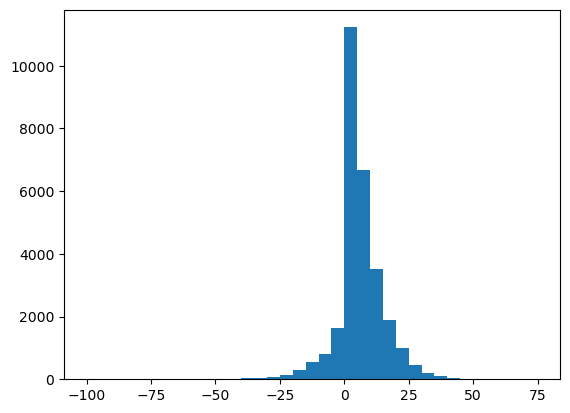

In [23]:
plt.hist(change_bapa["CHANGE_BAPA"], bins=np.arange(-100, 80, 5));

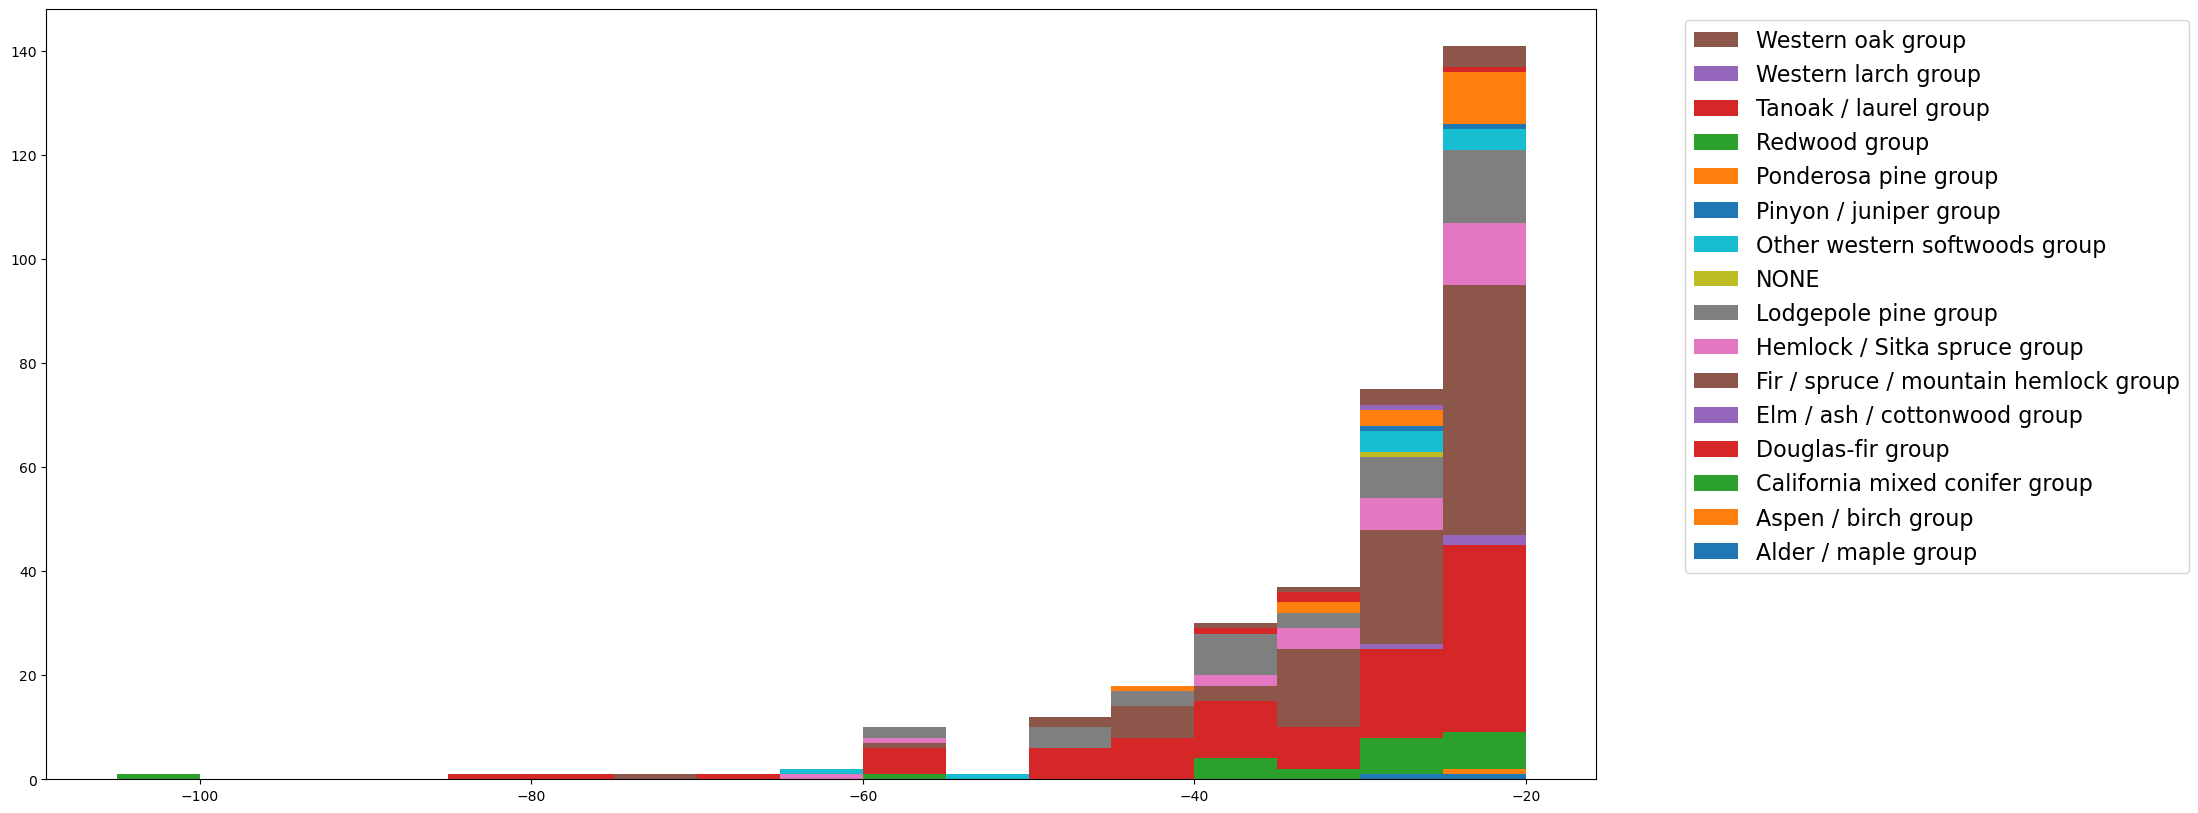

In [24]:
fig, ax = plt.subplots(figsize=(20, 10))

fortypes = np.unique(change_bapa.FORTYPGRP)
bins = np.unique(change_bapa.CHANGE_BAPA)
bins = bins[bins < -20]
groups = change_bapa.groupby(by=["FORTYPGRP", "CHANGE_BAPA"])["START_BAPA"].count()

for i, fortyp in enumerate(fortypes):
    data = groups.loc[fortyp].reindex(bins).fillna(0)
    if i == 0:
        bottom = np.zeros(bins.shape)
    if data.sum() > 0:
        ax.bar(
            data.index, data.values, bottom=bottom, label=fortyp, width=5, align="edge"
        ),
    bottom += data.values
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.05, 1.00), fontsize=16)
plt.show()

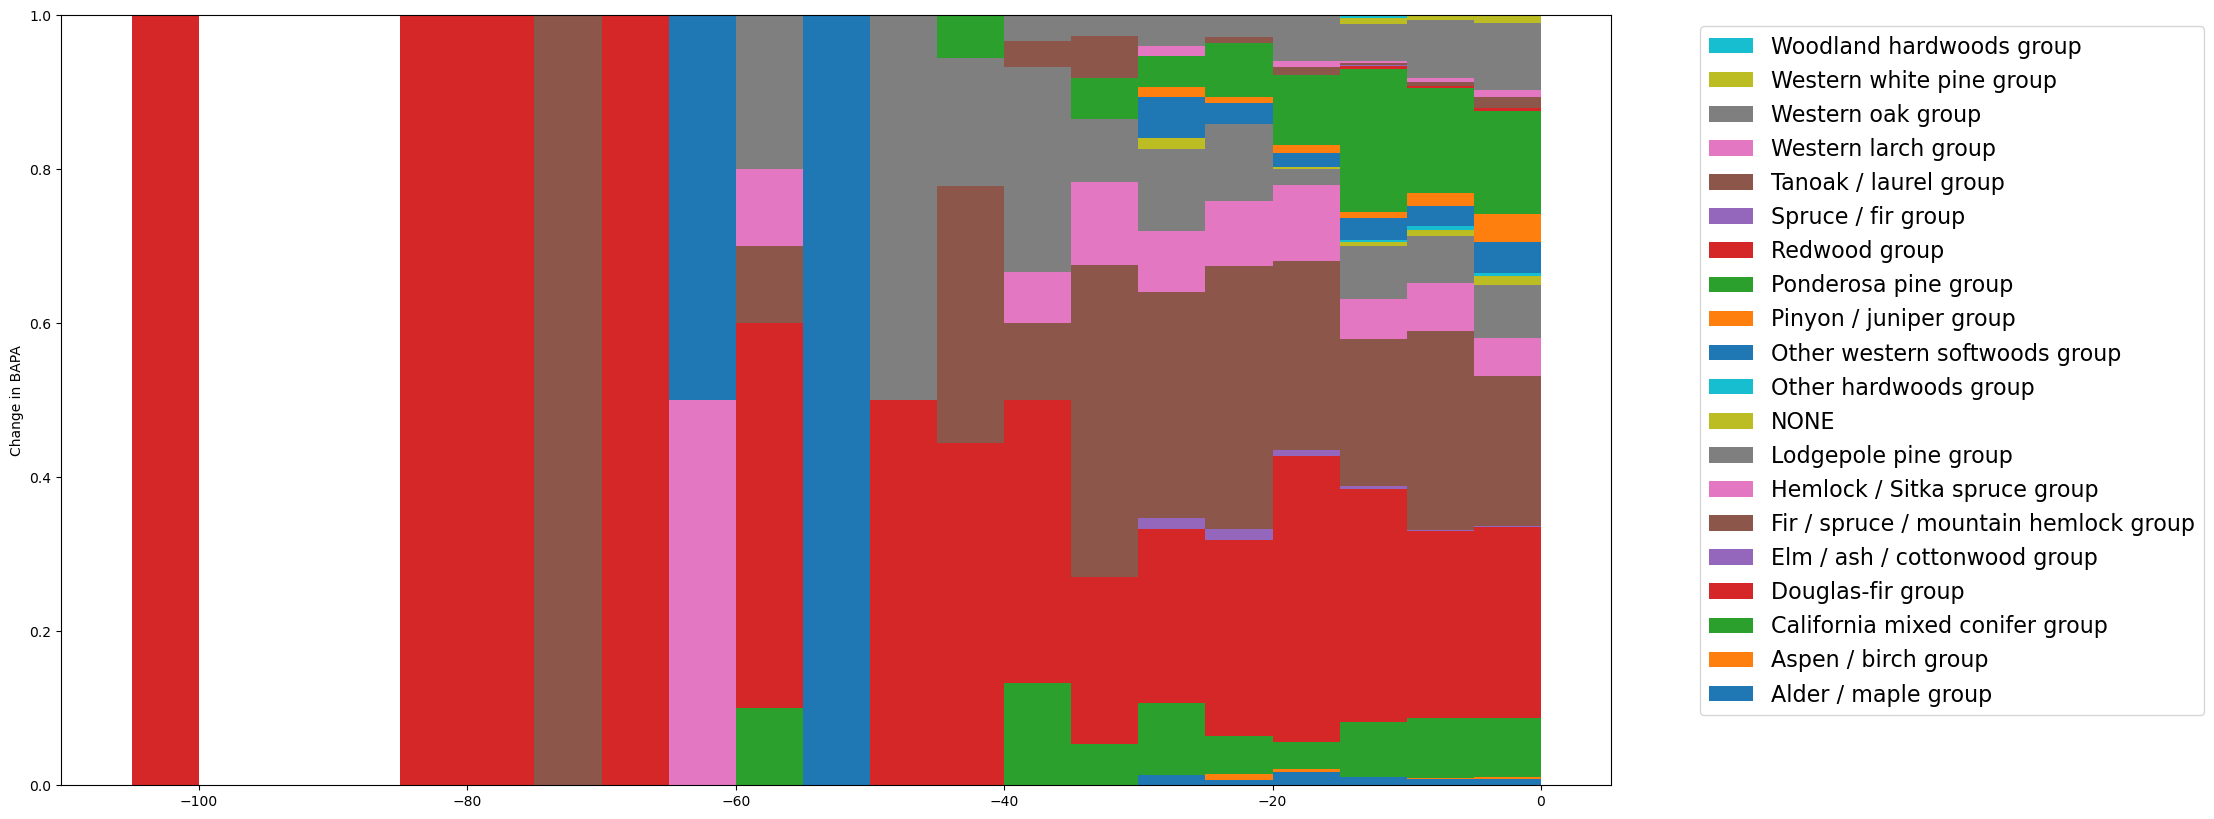

In [25]:
fig, ax = plt.subplots(figsize=(20, 10))

fortypes = np.unique(change_bapa.FORTYPGRP)
bins = np.unique(change_bapa.CHANGE_BAPA)
bins = bins[bins < 0]
groups = change_bapa.groupby(by=["FORTYPGRP", "CHANGE_BAPA"])["START_BAPA"].count()
counts = change_bapa.groupby(by=["CHANGE_BAPA"])["START_BAPA"].count().loc[bins]

for i, fortyp in enumerate(fortypes):
    data = groups.loc[fortyp].reindex(bins).fillna(0)
    if i == 0:
        bottom = np.zeros(bins.shape)
    if data.sum() > 0:
        ax.bar(
            data.index,
            data.values / counts.values,
            bottom=bottom,
            label=fortyp,
            width=5,
            align="edge",
        ),
    bottom += data.values / counts.values
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.05, 1.00), fontsize=16)
ax.set_ylabel("Change in BAPA")
plt.show()

In [26]:
DISPLAY_VALS = np.arange(-80, 90, 10)
pd.pivot(
    groups.reset_index(),
    index="FORTYPGRP",
    columns=["CHANGE_BAPA"],
    values="START_BAPA",
)[DISPLAY_VALS].fillna(0).style.format("{:,.0f}")

CHANGE_BAPA,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60,70,80
FORTYPGRP,,,,,,,,,,,,,,,,,
Alder / maple group,0,0,0,0,0,1,5,7,85,57,34,4,1,0,1,0,0
Aspen / birch group,0,0,0,0,0,0,1,1,12,1,1,1,0,0,0,0,0
California mixed conifer group,0,0,1,0,4,7,10,62,477,215,40,5,2,0,0,0,0
Douglas-fir group,1,1,5,6,11,17,106,194,"2,339","1,503",532,104,16,2,0,0,0
Elm / ash / cottonwood group,0,0,0,0,0,1,2,1,10,8,4,0,0,0,0,0,0
Fir / spruce / mountain hemlock group,0,0,1,0,3,22,70,207,"1,328",606,129,19,6,0,1,1,0
Hemlock / Sitka spruce group,0,0,1,0,2,6,28,50,292,226,93,22,7,0,2,0,1
Lodgepole pine group,0,0,2,4,8,8,6,49,700,230,49,11,1,2,0,0,0
NONE,0,0,0,0,0,1,1,6,234,12,2,1,0,0,0,0,0


In [27]:
good_conds = conds.loc[conds.PLOT_CN.isin(good_plots.PLOT_CN)].copy()

disturbances = pd.concat(
    [
        (
            good_conds.groupby(by=["DSTRBCD1", "PLOT_CN"])["COND_CN"]
            .count()
            .reset_index(level=1)["PLOT_CN"]
        ),
        (
            good_conds.groupby(by=["DSTRBCD2", "PLOT_CN"])["COND_CN"]
            .count()
            .reset_index(level=1)["PLOT_CN"]
        ),
        (
            good_conds.groupby(by=["DSTRBCD3", "PLOT_CN"])["COND_CN"]
            .count()
            .reset_index(level=1)["PLOT_CN"]
        ),
        (
            good_conds.groupby(by=["DSTRBCD4", "PLOT_CN"])["COND_CN"]
            .count()
            .reset_index(level=1)["PLOT_CN"]
        ),
    ],
    axis=0,
).to_frame()
disturbances.index = disturbances.index.astype(int)
disturbances

,PLOT_CN
0,174763094020004
0,174763095020004
0,174763100020004
0,174763104020004
0,174763105020004
...,...
0,558631003126144
0,558631004126144
0,558631005126144
0,558631006126144


In [28]:
disturbance_groups = disturbances.copy()
disturbance_groups = disturbance_groups.reset_index()
disturbance_groups["DIST_GRP"] = disturbance_groups["index"] // 10 * 10
disturbance_groups = (
    disturbance_groups.groupby(by=["DIST_GRP", "PLOT_CN"])["index"]
    .count()
    .reset_index(level=1)["PLOT_CN"]
)
disturbance_groups

DIST_GRP
0     174763094020004
0     174763095020004
0     174763096020004
0     174763100020004
0     174763104020004
           ...       
70     44541368020004
70     44541628020004
70     48204051010497
70     48205519010497
70    484819444489998
Name: PLOT_CN, Length: 15947, dtype: object

In [29]:
DIST_GRPS = {
    0: "UNDISTURBED",
    10: "INSECT",
    20: "DISEASE",
    30: "FIRE",
    40: "ANIMAL",
    50: "WEATHER",
    60: "VEGETATION",
    70: "UNKNOWN",
    80: "HUMAN",
    90: "GEOLOGIC",
}
for dist_type in np.unique(disturbance_groups.index):
    change_bapa[DIST_GRPS[dist_type]] = change_bapa.index.get_level_values(0).isin(
        disturbance_groups.loc[dist_type]
    )
    print(
        dist_type,
        (
            change_bapa.index.get_level_values(0)
            .isin(disturbance_groups.loc[dist_type])
            .sum()
        ),
    )

0 28764
10 2023
20 4076
40 1404
50 868
60 93
70 30


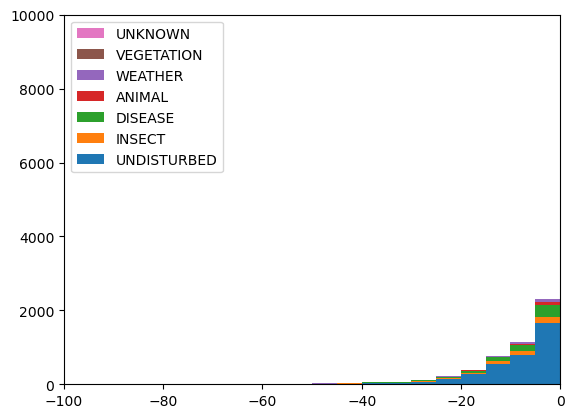

In [30]:
fig, ax = plt.subplots()
for i, dist_type in enumerate(
    [x for x in DIST_GRPS.values() if x in change_bapa.columns]
):
    dist = change_bapa.groupby(by=["CHANGE_BAPA"])[dist_type].sum()
    if i == 0:
        bottom = np.zeros_like(dist)
    plt.bar(
        dist.index, dist.values, bottom=bottom, label=dist_type, width=5, align="edge"
    ),
    bottom += dist.values
handles, labels = ax.get_legend_handles_labels()
ax.set_xlim(-100, 0)
ax.set_ylim(0, 10000)
ax.legend(handles[::-1], labels[::-1], loc="upper left")
plt.show()

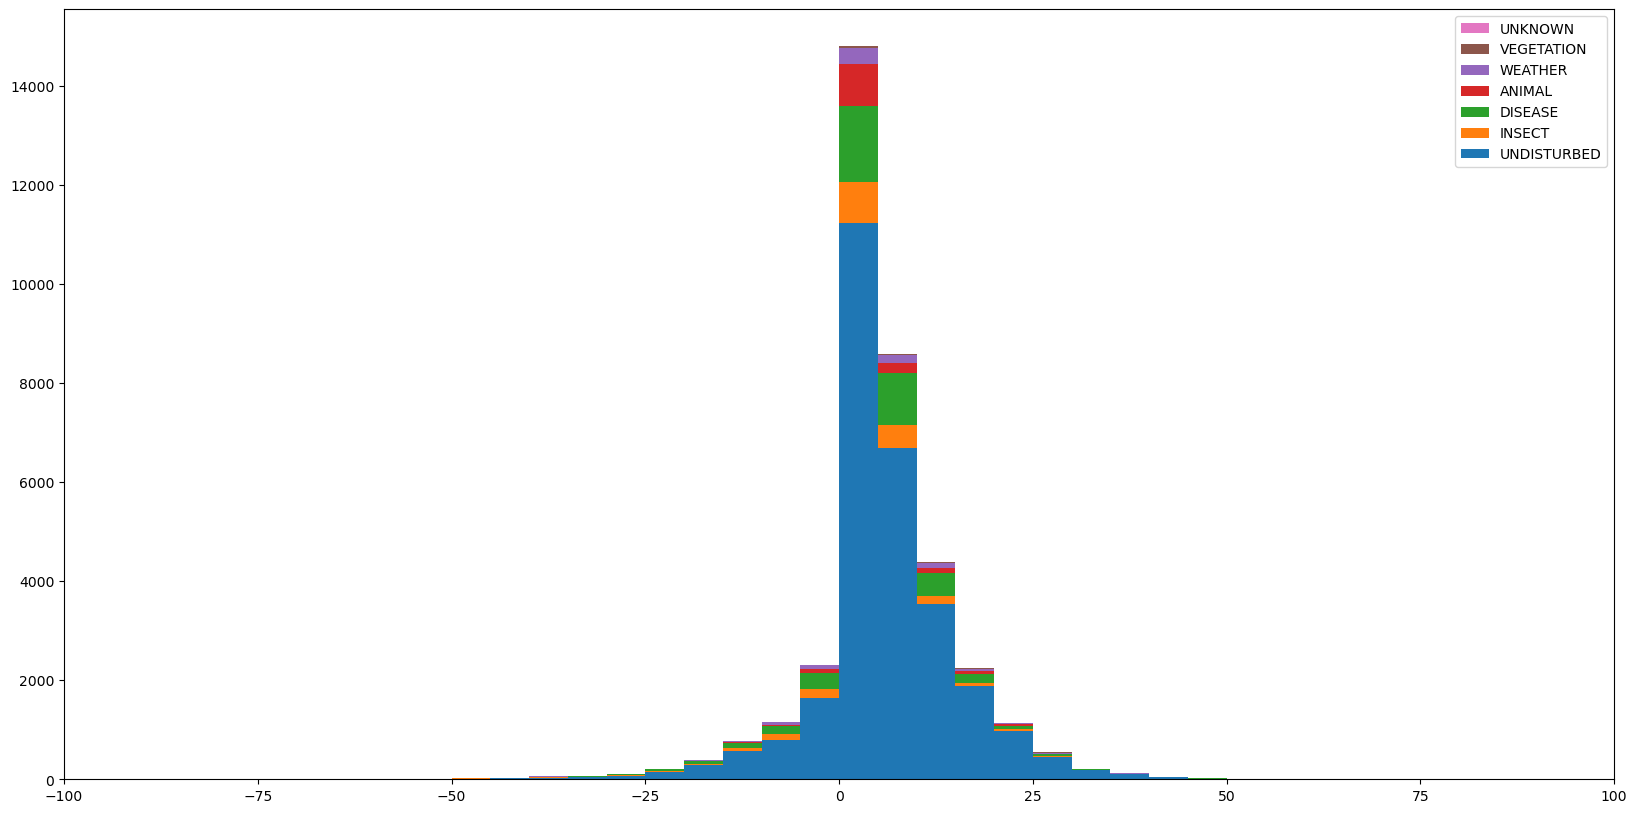

In [31]:
fig, ax = plt.subplots(figsize=(20, 10))
for i, dist_type in enumerate(
    [x for x in DIST_GRPS.values() if x in change_bapa.columns]
):
    dist = change_bapa.groupby(by=["CHANGE_BAPA"])[dist_type].sum()
    if i == 0:
        bottom = np.zeros_like(dist)
    plt.bar(
        dist.index, dist.values, bottom=bottom, label=dist_type, width=5, align="edge"
    ),
    bottom += dist.values
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])
ax.set_xlim(-100, 100)
plt.show()

In [32]:
dist_cols = [x for x in DIST_GRPS.values() if x in change_bapa.columns]
total_dist_counts = change_bapa.groupby(by=["CHANGE_BAPA"])[dist_cols].sum().sum(axis=1)
dist_counts = change_bapa.groupby(by=["CHANGE_BAPA"])[dist_cols].sum()
dist_counts["TOTAL"] = total_dist_counts
dist_counts.style.bar(vmin=0, vmax=total_dist_counts.max()).format("{:,.0f}")

,UNDISTURBED,INSECT,DISEASE,ANIMAL,WEATHER,VEGETATION,UNKNOWN,TOTAL
CHANGE_BAPA,,,,,,,,
-105,1,0,0,0,0,0,0,1
-85,1,1,1,0,0,0,0,3
-80,1,0,1,0,0,0,0,2
-75,1,0,0,0,0,0,0,1
-70,1,0,0,0,0,0,0,1
-65,2,1,0,0,0,0,0,3
-60,10,3,1,0,0,0,0,14
-55,1,1,0,0,0,0,0,2
-50,12,7,2,0,1,0,0,22


In [33]:
dist_counts.divide(total_dist_counts.sum(), axis=0).style.format("{:.0%}")

,UNDISTURBED,INSECT,DISEASE,ANIMAL,WEATHER,VEGETATION,UNKNOWN,TOTAL
CHANGE_BAPA,,,,,,,,
-105,0%,0%,0%,0%,0%,0%,0%,0%
-85,0%,0%,0%,0%,0%,0%,0%,0%
-80,0%,0%,0%,0%,0%,0%,0%,0%
-75,0%,0%,0%,0%,0%,0%,0%,0%
-70,0%,0%,0%,0%,0%,0%,0%,0%
-65,0%,0%,0%,0%,0%,0%,0%,0%
-60,0%,0%,0%,0%,0%,0%,0%,0%
-55,0%,0%,0%,0%,0%,0%,0%,0%
-50,0%,0%,0%,0%,0%,0%,0%,0%


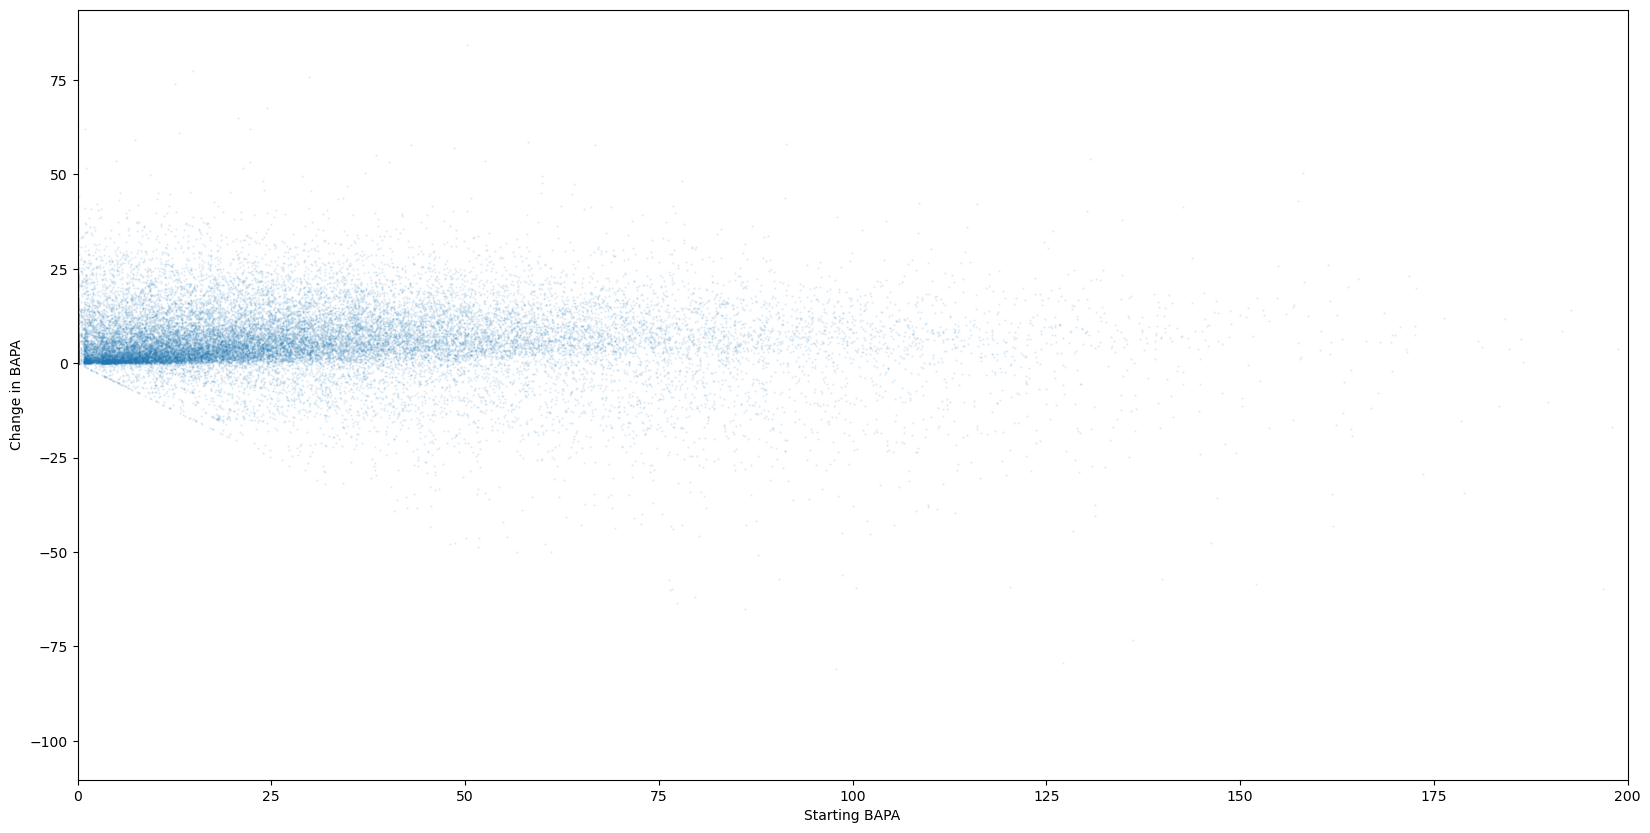

In [34]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(
    change_bapa.START_BAPA,
    change_bapa.END_BAPA - change_bapa.START_BAPA,
    s=0.5,
    alpha=0.1,
)
ax.set_xlim(0, 200)
ax.set_xlabel("Starting BAPA")
ax.set_ylabel("Change in BAPA")
plt.show();

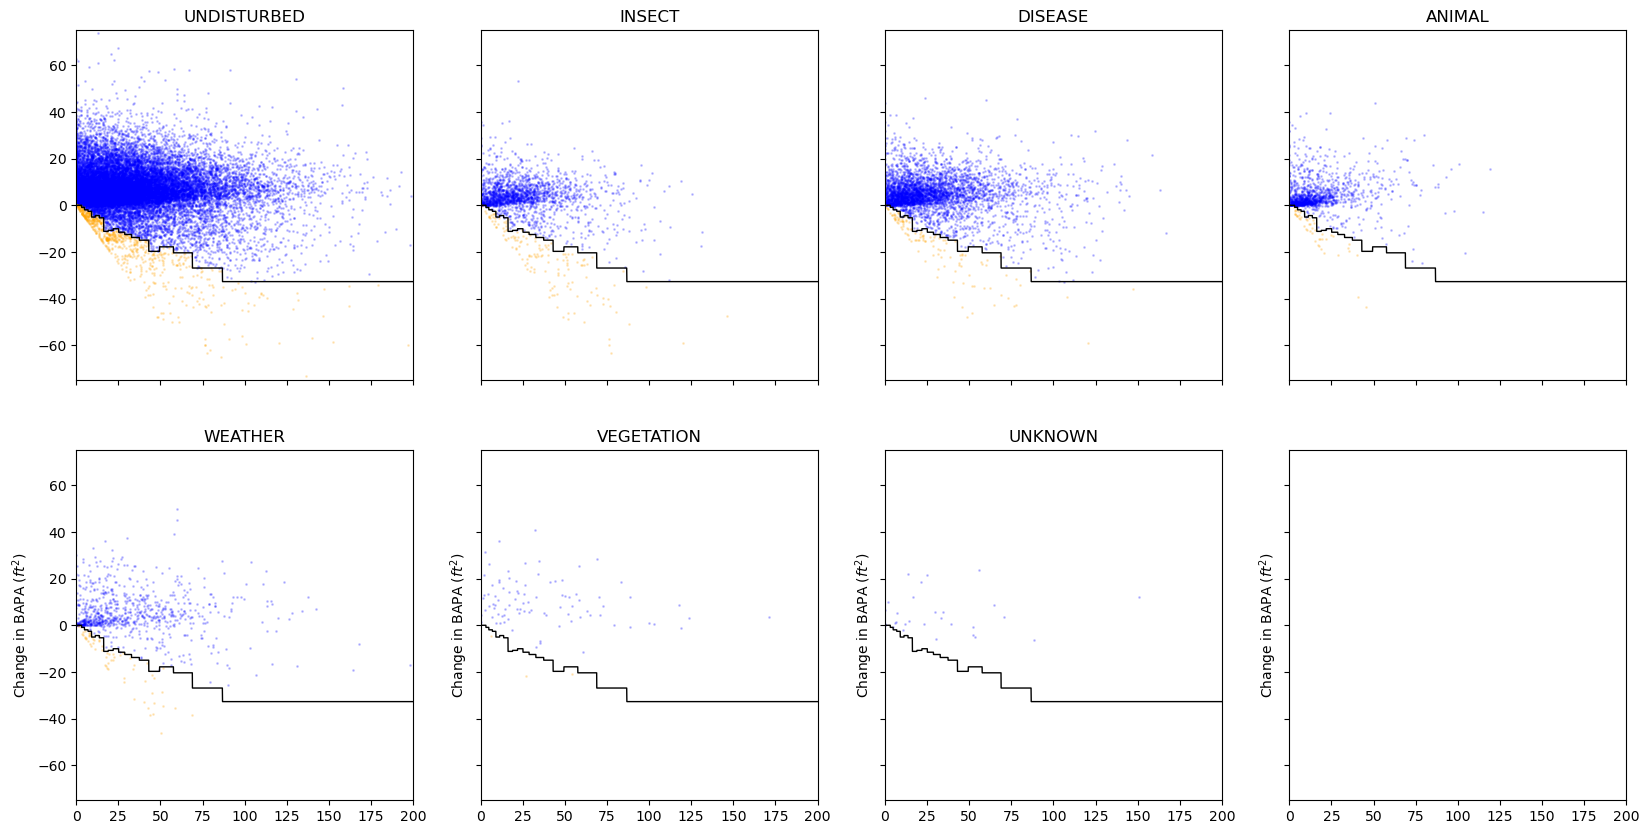

In [35]:
CUTOFF_PCT = 0.025
quantile_change = change_bapa.copy()
quantile_change["CHANGE_BAPA"] = (
    quantile_change["END_BAPA"] - quantile_change["START_BAPA"]
)
quantile_change["START_BAPA_BIN"] = pd.qcut(
    quantile_change.START_BAPA, 20, labels=False
)
cutoffs = quantile_change.groupby(by=["START_BAPA_BIN"])["CHANGE_BAPA"].quantile(
    q=CUTOFF_PCT
)
quantile_change["CUTOFF"] = cutoffs.reindex(quantile_change.START_BAPA_BIN).values
plot_cutoff = quantile_change.sort_values("START_BAPA")[
    ["START_BAPA", "CUTOFF"]
].drop_duplicates("START_BAPA")

fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(20, 10))
dist_cols = [x for x in DIST_GRPS.values() if x in change_bapa.columns]

for i, dist_type in enumerate(dist_cols):
    data = quantile_change.loc[quantile_change[dist_type]].copy()
    axs.ravel()[i].scatter(
        data.loc[data.CHANGE_BAPA >= data.CUTOFF, "START_BAPA"],
        data.loc[data.CHANGE_BAPA >= data.CUTOFF, "CHANGE_BAPA"],
        s=1.0,
        alpha=0.2,
        color="blue",
    )
    axs.ravel()[i].scatter(
        data.loc[data.CHANGE_BAPA < data.CUTOFF, "START_BAPA"],
        data.loc[data.CHANGE_BAPA < data.CUTOFF, "CHANGE_BAPA"],
        s=1.0,
        alpha=0.2,
        color="orange",
    )
    axs.ravel()[i].set_title(dist_type)
    axs.ravel()[i].plot(
        plot_cutoff.START_BAPA, plot_cutoff.CUTOFF, lw=1.0, color="black"
    )
axs.ravel()[0].set_ylim(-75, 75)
axs.ravel()[0].set_xlim(0, 200)
for ax in axs[-1, :]:
    ax.set_ylabel("Change in BAPA ($ft^2$)")
plt.show()

In [36]:
# decided not to throw out extreme mortality events because they may correspond to conditions we want to model (e.g., drought, vulnerable stages of stand development).

In [37]:
print(len(np.unique(plots.PLOT_CN)))
print(len(np.unique(plots_with_trees.PLOT_CN)))
print(len(np.unique(remeasured_plots.index)))
print(len(np.unique(good_plots.PLOT_CN)))
print(
    len(np.unique(good_plots.PLOT_CN))
    - len(
        np.unique(
            quantile_change.loc[
                quantile_change.CHANGE_BAPA < quantile_change.CUTOFF
            ].index.get_level_values(0)
        )
    )
)

94231
37709
14076
12154
11498


In [38]:
# print(len(trees.loc[trees.PLOT_CN.isin(np.unique(plots.PLOT_CN))]))
# print(len(trees.loc[trees.PLOT_CN.isin(np.unique(plots_with_trees.PLOT_CN))]))
print(len(trees.loc[trees.PLOT_CN.isin(np.unique(remeasured_plots.index))]))
print(len(trees.loc[trees.PLOT_CN.isin(np.unique(good_plots.PLOT_CN))]))
remeasured_trees_on_good_plots = good_trees.loc[~pd.isnull(good_trees.TREE_CN_PREV)]
print(len(remeasured_trees_on_good_plots))

298678
269952
211300


In [39]:
abund_spp = (
    remeasured_trees_on_good_plots.groupby(by=["COMMON_NAME"])["TREE_CN"]
    .count()
    .sort_values(ascending=False)
    .index
)
abund_spp_coast = (
    remeasured_trees_on_good_plots.loc[
        remeasured_trees_on_good_plots.VARIANT.isin(["PN", "NC"])
    ]
    .groupby(by=["COMMON_NAME"])["TREE_CN"]
    .count()
    .sort_values(ascending=False)
    .index
)
tree_counts = remeasured_trees_on_good_plots.groupby(by=["VARIANT", "COMMON_NAME"])[
    "TREE_CN"
].count()
pivot_counts = (
    pd.pivot(
        tree_counts.reset_index(),
        index=["COMMON_NAME"],
        columns=["VARIANT"],
        values=["TREE_CN"],
    )
    .fillna(0)
    .astype(int)["TREE_CN"]
)
VAR_ORDER = (
    pivot_counts.loc[abund_spp_coast[0:50]]
    .sum(axis=0)
    .drop(["PN", "NC", "CR"])
    .sort_values(ascending=False)
    .index
)
(
    pivot_counts.loc[abund_spp_coast[0:30]][
        VAR_ORDER.insert(0, "NC").insert(0, "PN")
    ].style.format("{:,.0f}")
)

VARIANT,PN,NC,WC,SO,EC,BM,CA,WS,IE,AK
COMMON_NAME,,,,,,,,,,
Douglas-fir,"12,719","5,085","20,045",344,"7,213","4,336","4,460","1,075","1,073",134
western hemlock,"4,468",193,"8,301",22,795,0,46,0,240,422
tanoak,1,"2,770",2,0,0,0,263,110,0,0
redwood,0,"1,990",0,0,0,0,0,0,0,0
red alder,"1,476",81,663,0,23,5,10,1,0,41
western redcedar,"1,103",4,"2,039",0,421,0,8,0,666,67
canyon live oak,2,886,8,0,0,0,"2,020","1,220",0,0
Pacific madrone,75,717,244,0,0,0,913,24,0,0
bigleaf maple,617,145,579,0,41,0,126,55,0,5


# Merge remeasurements of trees together and add location information

In [40]:
start_trees = trees.loc[trees.PLOT_CN.isin(good_plots.PLOT_CN_PREV)].copy()
start_trees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220598 entries, 843 to 1612603
Data columns (total 33 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   STATECD          220598 non-null  Int64  
 1   UNITCD           220598 non-null  Int64  
 2   COUNTYCD         220598 non-null  Int64  
 3   PLOT             220598 non-null  Int64  
 4   SUBPLOT          220598 non-null  Int64  
 5   CONDID           220598 non-null  Int64  
 6   PLOT_ID          220598 non-null  int64  
 7   SUBPLOT_ID       220598 non-null  float64
 8   PLOT_CN          220598 non-null  object 
 9   PLOT_CN_PREV     14780 non-null   object 
 10  SUBPLOT_CN       220598 non-null  object 
 11  SUBPLOT_CN_PREV  7379 non-null    object 
 12  TREE_CN          220598 non-null  object 
 13  TREE_CN_PREV     11157 non-null   object 
 14  TREE_ID          200172 non-null  object 
 15  INVYR            220598 non-null  Int64  
 16  AZIMUTH          199458 non-null  f

In [41]:
end_trees = trees.loc[trees.PLOT_CN.isin(good_plots.PLOT_CN)].copy()
end_trees = end_trees.rename(
    {
        "DBH": "DBH_NEXT",
        "HT": "HT_NEXT",
        "ACTUALHT": "ACTUALHT_NEXT",
        "CR": "CR_NEXT",
        "INVYR": "INVYR_NEXT",
        "MORTYR": "MORTYR_NEXT",
        "STATUSCD": "STATUSCD_NEXT",
        "PLOT_CN": "PLOT_CN_NEXT",
        "TREE_CN": "TREE_CN_NEXT",
    },
    axis=1,
)
end_trees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269952 entries, 844 to 1612606
Data columns (total 33 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   STATECD          269952 non-null  Int64  
 1   UNITCD           269952 non-null  Int64  
 2   COUNTYCD         269952 non-null  Int64  
 3   PLOT             269952 non-null  Int64  
 4   SUBPLOT          269952 non-null  Int64  
 5   CONDID           269952 non-null  Int64  
 6   PLOT_ID          269952 non-null  int64  
 7   SUBPLOT_ID       269952 non-null  float64
 8   PLOT_CN_NEXT     269952 non-null  object 
 9   PLOT_CN_PREV     269952 non-null  object 
 10  SUBPLOT_CN       269952 non-null  object 
 11  SUBPLOT_CN_PREV  0 non-null       object 
 12  TREE_CN_NEXT     269952 non-null  object 
 13  TREE_CN_PREV     200143 non-null  object 
 14  TREE_ID          249649 non-null  object 
 15  INVYR_NEXT       269952 non-null  Int64  
 16  AZIMUTH          248956 non-null  f

In [42]:
plot_lookup = plots.set_index("PLOT_CN")
plot_lookup.columns

Index(['STATECD', 'UNITCD', 'COUNTYCD', 'PLOT', 'PLOT_ID', 'PLOT_CN_PREV',
       'MEASYEAR', 'MEASMON', 'MEASDAY', 'REMPER', 'DESIGNCD', 'LAT', 'LON',
       'ELEV', 'TOPO_POSITION_PNW', 'VARIANT', 'LOCATION', 'SLOPE', 'ASPECT',
       'FORTYPCD', 'FORTYPNM', 'FORTYPGRP', 'SICOND', 'SIBASE', 'SISP'],
      dtype='object')

In [43]:
plot_lookup.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94231 entries, 64 to 29091
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   STATECD            94231 non-null  int64  
 1   UNITCD             94231 non-null  int64  
 2   COUNTYCD           94231 non-null  int64  
 3   PLOT               94231 non-null  int64  
 4   PLOT_ID            94231 non-null  int64  
 5   PLOT_CN_PREV       39653 non-null  object 
 6   MEASYEAR           94231 non-null  int64  
 7   MEASMON            94205 non-null  float64
 8   MEASDAY            94205 non-null  float64
 9   REMPER             39466 non-null  float64
 10  DESIGNCD           94231 non-null  int64  
 11  LAT                93787 non-null  float64
 12  LON                93787 non-null  float64
 13  ELEV               87721 non-null  float64
 14  TOPO_POSITION_PNW  42006 non-null  object 
 15  VARIANT            77213 non-null  object 
 16  LOCATION           77213 n

In [44]:
coords_lookup = plot_lookup.dropna(subset=["LAT", "LON"]).groupby(by="PLOT_ID").first()
variant_lookup = plot_lookup.dropna(subset=["VARIANT", "LOCATION"]).groupby(
    by="PLOT_ID"
)

In [45]:
FVS_SPP = "../../data/interim/fvs_speciescrosswalk.csv"
fvs_spp = pd.read_csv(FVS_SPP)
fvs_spp.columns = [col.upper() for col in fvs_spp.columns]
fvs_spp = fvs_spp.dropna(subset=["FIA_SPCD"])
fvs_spp["FIA_SPCD"] = fvs_spp["FIA_SPCD"].astype(int)
lookup_fvsalpha = fvs_spp.set_index("FVS_ALPHA")
lookup_fiafvs = fvs_spp.set_index("FIA_SPCD")

In [46]:
lookup_fiafvs.columns

Index(['USDA_PLANTS_SYMBOL', 'FVS_ALPHA', 'COMMON_NAME', 'SCIENTIFIC_NAME',
       'AK_MAPPED_TO', 'BM_MAPPED_TO', 'CA_MAPPED_TO', 'CI_MAPPED_TO',
       'CR_MAPPED_TO', 'EC_MAPPED_TO', 'EM_MAPPED_TO', 'IE_MAPPED_TO',
       'KT_MAPPED_TO', 'NC_MAPPED_TO', 'NI_MAPPED_TO', 'PN_MAPPED_TO',
       'SO_MAPPED_TO', 'TT_MAPPED_TO', 'UT_MAPPED_TO', 'WC_MAPPED_TO',
       'WS_MAPPED_TO', 'OC_MAPPED_TO', 'OP_MAPPED_TO'],
      dtype='object')

In [47]:
# np.unique(fvs_vars.FVSVariant)

In [48]:
FVS_VARS = "../../data/raw/FVS_Variants_and_Locations.shp"
KEEP_VARS = ["AK", "BM", "CA", "CR", "EC", "IE", "NC", "PN", "SO", "WC", "WS"]
fvs_vars = gpd.read_file(FVS_VARS)
fvs_vars = fvs_vars.loc[fvs_vars.FVSVariant.isin(KEEP_VARS)].copy()
fvs_vars["geometry"] = fvs_vars.geometry.buffer(0)
fvs_vars = fvs_vars.to_crs(4326)
fvs_vars.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 122 entries, 1 to 256
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    122 non-null    int64   
 1   Shape_Leng  122 non-null    float64 
 2   Shape_Area  122 non-null    float64 
 3   FVSVariant  122 non-null    object  
 4   FVSVarName  122 non-null    object  
 5   FVSLocCode  122 non-null    int64   
 6   FVSLocName  122 non-null    object  
 7   geometry    122 non-null    geometry
dtypes: float64(2), geometry(1), int64(2), object(3)
memory usage: 8.6+ KB


In [49]:
SPP_IDX = "../../data/interim/fvs_spp_indexes.csv"
spp_idx = pd.read_csv(SPP_IDX).set_index(["VARIANT", "FVS_ALPHA"])
spp_idx.head()

VAR_SPP_IDX
VARIANT FVS_ALPHA             
AK      SF                   1
        AF                   2
        YC                   3
        TA                   4
        WS                   5

In [50]:
# spp_idx.reindex(pd.MultiIndex.from_frame(merge_trees[['VARIANT', 'FVS_ALPHA']])).values[:,0].astype(int)

In [51]:
KEEP_END = [
    "STATECD",
    "UNITCD",
    "COUNTYCD",
    "PLOT",
    "PLOT_ID",
    "SUBPLOT",
    "SUBPLOT_ID",
    "TREE_ID",
    "AZIMUTH",
    "DISTANCE",
    "PLOT_CN_PREV",
    "PLOT_CN_NEXT",
    "TREE_CN_PREV",
    "TREE_CN_NEXT",
    "TPA_UNADJ",
    "SPECIES",
    "COMMON_NAME",
    "DBH_NEXT",
    "HT_NEXT",
    "ACTUALHT_NEXT",
    "CR_NEXT",
    "STATUSCD_NEXT",
    "MORTYR_NEXT",
    "INC10YR",
    "INC5YR",
]
DROP_START = ["PLOT_CN_PREV", "SUBPLOT_CN_PREV", "TREE_CN_PREV", "CONDID", "SUBPLOT_CN", "INC10YR", "INC5YR"]
DROP_MERGE = ["PLOT_CN_PREV", "TREE_CN_PREV"]
merge_trees = start_trees.drop(DROP_START, axis=1).merge(
    end_trees[KEEP_END],
    left_on=["PLOT_CN", "SUBPLOT_ID", "TREE_CN"],
    right_on=["PLOT_CN_PREV", "SUBPLOT_ID", "TREE_CN_PREV"],
    how="outer",
)

UPDATE_COLS = [
    "STATECD",
    "UNITCD",
    "COUNTYCD",
    "PLOT",
    "PLOT_ID",
    "SUBPLOT",
    "TREE_ID",
    "TPA_UNADJ",
    "AZIMUTH",
    "DISTANCE",
    "SPECIES",
    "COMMON_NAME",
]
for col in UPDATE_COLS:
    filt = pd.isnull(merge_trees[f"{col}_x"])
    merge_trees.loc[filt, f"{col}_x"] = merge_trees.loc[filt, f"{col}_y"]
    merge_trees = merge_trees.drop(f"{col}_y", axis=1).rename({f"{col}_x": col}, axis=1)

UPDATE_PREV = ["PLOT_CN", "TREE_CN"]
for col in UPDATE_PREV:
    filt = pd.isnull(merge_trees[f"{col}"])
    merge_trees.loc[filt, f"{col}"] = merge_trees.loc[filt, f"{col}_PREV"]
    merge_trees = merge_trees.drop(f"{col}_PREV", axis=1)

LOOKUP_COLS = ["MEASYEAR", "MEASMON", "MEASDAY"]
remeas_lookup = remeasured_plots.reset_index().set_index("PLOT_CN_PREV")
for col in LOOKUP_COLS:
    merge_trees[col] = plot_lookup.reindex(merge_trees.PLOT_CN)[col].values
    merge_trees[f"{col}_NEXT"] = remeas_lookup.reindex(merge_trees.PLOT_CN)[col].values
merge_trees[f"PLOT_CN_NEXT"] = remeas_lookup.reindex(merge_trees.PLOT_CN)[
    "PLOT_CN"
].values

LOCATION_COLS = [
    "LAT",
    "LON",
    "ELEV",
    "VARIANT",
    "LOCATION",
    "SLOPE",
    "ASPECT",
    "TOPO_POSITION_PNW",
    # "SICOND",
    # "SIBASE",
    # "SISP",
]
for col in LOCATION_COLS:
    merge_trees[col] = plot_lookup.reindex(merge_trees["PLOT_CN"])[col].values
for col in LOCATION_COLS:
    filt = pd.isnull(merge_trees[col])
    lookup = plots.dropna(subset=[col]).groupby("PLOT_ID")[col].first()
    merge_trees.loc[filt, col] = lookup.reindex(merge_trees.loc[filt, "PLOT_ID"]).values

COND_COLS = ["SICOND", "SIBASE", "SISP", "SITECLCD", "VOL_LOC_GRP", "PLANT_STOCKABILITY_FACTOR_PNW"]
for col in COND_COLS:
    lookup = conds.dropna(subset=[col]).groupby("PLOT_ID")[col].first()
    merge_trees[col] = lookup.reindex(merge_trees.PLOT_ID).values

UPDATE_COND_COLS = ["SICOND", "SIBASE", "SISP", "SLOPE", "ASPECT"]
for col in UPDATE_COND_COLS:
    filt = pd.isnull(merge_trees[col])
    lookup = conds.dropna(subset=[col]).groupby("PLOT_ID")[col].first()
    merge_trees.loc[filt, col] = lookup.reindex(merge_trees.loc[filt, "PLOT_ID"]).values

filt = pd.isnull(merge_trees.VARIANT)
pts = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(
        merge_trees.loc[filt, "LON"].values, merge_trees.loc[filt, "LAT"].values
    ),
    crs=4326,
)
pts.index = merge_trees.loc[filt].index
sjoin = gpd.sjoin(pts, fvs_vars, how="left").dropna().groupby(level=0).first()
merge_trees.VARIANT.update(sjoin["FVSVariant"])
merge_trees.LOCATION.update(sjoin["FVSLocCode"])
merge_trees = merge_trees.dropna(subset=["VARIANT"])
merge_trees["VARIANT"] = merge_trees.VARIANT.replace("AK", "PN")

merge_trees["FVS_ALPHA"] = lookup_fiafvs.reindex(merge_trees.SPECIES)[
    "FVS_ALPHA"
].values
merge_trees = merge_trees.rename({"SPECIES": "FIA_SPCD"}, axis=1)
merge_trees["FVS_SPP"] = np.nan
for var in np.unique(merge_trees.VARIANT):
    filt = merge_trees.VARIANT == var
    merge_trees.loc[filt, "FVS_SPP"] = lookup_fiafvs.reindex(
        merge_trees.loc[filt, "FIA_SPCD"].values
    )[f"{var}_MAPPED_TO"].values
merge_trees["FVS_SPP_IDX"] = (
    spp_idx.reindex(pd.MultiIndex.from_frame(merge_trees[["VARIANT", "FVS_SPP"]]))
    .values[:, 0]
    .astype(int)
)

COL_ORDER = [
    "STATECD",
    "UNITCD",
    "COUNTYCD",
    "PLOT",
    "PLOT_ID",
    "SUBPLOT",
    "SUBPLOT_ID",
    "PLOT_CN",
    "PLOT_CN_NEXT",
    "TREE_CN",
    "TREE_CN_NEXT",
    "TREE_ID",
    "LAT",
    "LON",
    "ELEV",
    "VARIANT",
    "LOCATION",
    "SLOPE",
    "ASPECT",
    "TOPO_POSITION_PNW",
    "MEASYEAR",
    "MEASMON",
    "MEASDAY",
    "MEASYEAR_NEXT",
    "MEASMON_NEXT",
    "MEASDAY_NEXT",
    "SICOND",
    "SIBASE",
    "SISP",
    "SITECLCD",
    "VOL_LOC_GRP", 
    "PLANT_STOCKABILITY_FACTOR_PNW",
    "AZIMUTH",
    "DISTANCE",
    "STATUSCD",
    "STATUSCD_NEXT",
    "MORTYR",
    "MORTYR_NEXT",
    "TPA_UNADJ",
    "FIA_SPCD",
    "FVS_ALPHA",
    "FVS_SPP",
    "FVS_SPP_IDX",
    "COMMON_NAME",
    "DBH",
    "DBH_NEXT",
    "HT",
    "HT_NEXT",
    "ACTUALHT",
    "ACTUALHT_NEXT",
    "CR",
    "CR_NEXT",
    "CCLCD",
    "INC10YR",
    "INC5YR",
]
merge_trees = (
    merge_trees[COL_ORDER]
    .copy()
    .sort_values(by=["PLOT_ID", "TREE_CN", "TREE_CN_NEXT"])
    .reset_index(drop=True)
)
merge_trees["TREE_ID"] = merge_trees.index
merge_trees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290429 entries, 0 to 290428
Data columns (total 55 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   STATECD                        290429 non-null  Int64  
 1   UNITCD                         290429 non-null  Int64  
 2   COUNTYCD                       290429 non-null  Int64  
 3   PLOT                           290429 non-null  Int64  
 4   PLOT_ID                        290429 non-null  float64
 5   SUBPLOT                        290429 non-null  Int64  
 6   SUBPLOT_ID                     290429 non-null  float64
 7   PLOT_CN                        290429 non-null  object 
 8   PLOT_CN_NEXT                   290429 non-null  object 
 9   TREE_CN                        220620 non-null  object 
 10  TREE_CN_NEXT                   269952 non-null  object 
 11  TREE_ID                        290429 non-null  int64  
 12  LAT                           

In [52]:
merge_trees.groupby(by=["VARIANT"])["TREE_CN"].count()

VARIANT
BM    24985
CA    20093
CR      155
EC    24098
IE     4796
NC    16901
PN    24759
SO    30181
WC    52807
WS    21845
Name: TREE_CN, dtype: int64

In [53]:
def chapman_richards(dbh, b0, b1, b2):
    return 4.5 + b0 * (1 - np.exp(-b1 * dbh)) ** b2


HT_COEFS = "../../data/interim/ht_diam_coefs_chapman_richards.csv"
ht_coefs = pd.read_csv(HT_COEFS).set_index(["FIA_SPCD", "LOCATION"])

merge_trees[["b0", "b1", "b2"]] = ht_coefs.reindex(
    pd.MultiIndex.from_frame(merge_trees[["FIA_SPCD", "LOCATION"]])
).values

merge_trees["ESTHT"] = chapman_richards(
    merge_trees.DBH, merge_trees.b0, merge_trees.b1, merge_trees.b2
)
merge_trees["ESTHT_NEXT"] = chapman_richards(
    merge_trees.DBH_NEXT, merge_trees.b0, merge_trees.b1, merge_trees.b2
)
merge_trees["HT"] = merge_trees["ACTUALHT"]
merge_trees["HT_NEXT"] = merge_trees["ACTUALHT_NEXT"]

merge_trees.loc[pd.isnull(merge_trees.HT), "HT"] = merge_trees.loc[
    pd.isnull(merge_trees.HT), "ESTHT"
]
merge_trees.loc[pd.isnull(merge_trees.HT_NEXT), "HT_NEXT"] = merge_trees.loc[
    pd.isnull(merge_trees.HT_NEXT), "ESTHT_NEXT"
]

merge_trees = merge_trees.drop(["b0", "b1", "b2"], axis=1)

merge_trees[["PLOT_ID", "SUBPLOT_ID"]] = merge_trees[["PLOT_ID", "SUBPLOT_ID"]].astype(
    int
)

merge_trees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290429 entries, 0 to 290428
Data columns (total 57 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   STATECD                        290429 non-null  Int64  
 1   UNITCD                         290429 non-null  Int64  
 2   COUNTYCD                       290429 non-null  Int64  
 3   PLOT                           290429 non-null  Int64  
 4   PLOT_ID                        290429 non-null  int64  
 5   SUBPLOT                        290429 non-null  Int64  
 6   SUBPLOT_ID                     290429 non-null  int64  
 7   PLOT_CN                        290429 non-null  object 
 8   PLOT_CN_NEXT                   290429 non-null  object 
 9   TREE_CN                        220620 non-null  object 
 10  TREE_CN_NEXT                   269952 non-null  object 
 11  TREE_ID                        290429 non-null  int64  
 12  LAT                           

In [54]:
len(
    merge_trees.loc[
        (merge_trees.DBH > 0)
        & (merge_trees.DBH_NEXT > 0)
        & (merge_trees.STATUSCD == 1)
        & (merge_trees.STATUSCD_NEXT == 1)
    ]
)

178087

In [55]:
len(
    merge_trees.loc[
        (merge_trees.DBH > 0)
        & (merge_trees.STATUSCD == 1)
        & (merge_trees.STATUSCD_NEXT == 1)
    ]
)

178087

In [56]:
len(
    merge_trees.loc[
        (merge_trees.DBH > 0)
        & (merge_trees.STATUSCD == 1)
        & (merge_trees.STATUSCD_NEXT == 2)
    ]
)

8990

In [57]:
observed_death = (
    (merge_trees.DBH > 0)
    & (merge_trees.STATUSCD == 1)
    & (merge_trees.STATUSCD_NEXT == 2)
)
all_observed = (merge_trees.DBH > 0) & (merge_trees.STATUSCD == 1)
death_count = (
    merge_trees.loc[observed_death]
    .groupby(by=["COMMON_NAME"])["TREE_CN"]
    .count()
    .sort_values(ascending=False)
)
all_count = (
    merge_trees.loc[all_observed]
    .groupby(by=["COMMON_NAME"])["TREE_CN"]
    .count()
    .sort_values(ascending=False)
)
death_counts = pd.concat([death_count, all_count], axis=1).fillna(0).astype(int)
death_counts.columns = ["DIED", "OBSERVED"]
death_counts["MORTALITY_RATE"] = death_counts["DIED"] / death_counts["OBSERVED"]
death_counts.head(20)

,DIED,OBSERVED,MORTALITY_RATE
COMMON_NAME,,,
Douglas-fir,2168,54789,0.039570
lodgepole pine,1264,15934,0.079327
ponderosa pine,761,24299,0.031318
white fir,604,10174,0.059367
western hemlock,553,15332,0.036068
Pacific silver fir,420,9082,0.046245
grand fir,366,7060,0.051841
subalpine fir,244,3772,0.064687
red alder,221,2403,0.091968


In [58]:
len(
    merge_trees.loc[
        (merge_trees.DBH > 0)
        & (merge_trees.STATUSCD == 2)
        & (merge_trees.STATUSCD_NEXT == 1)
    ]
)

45

In [59]:
from refit_fvs.data.ccf.ccfcal_ak import ccfcal as ccfcal_ak
from refit_fvs.data.ccf.ccfcal_bm import ccfcal as ccfcal_bm
from refit_fvs.data.ccf.ccfcal_ca import ccfcal as ccfcal_ca
from refit_fvs.data.ccf.ccfcal_cr import ccfcal as ccfcal_cr
from refit_fvs.data.ccf.ccfcal_ec import ccfcal as ccfcal_ec
from refit_fvs.data.ccf.ccfcal_ie import ccfcal as ccfcal_ie
from refit_fvs.data.ccf.ccfcal_nc import ccfcal as ccfcal_nc
from refit_fvs.data.ccf.ccfcal_pn import ccfcal as ccfcal_pn
from refit_fvs.data.ccf.ccfcal_so import ccfcal as ccfcal_so
from refit_fvs.data.ccf.ccfcal_wc import ccfcal as ccfcal_wc
from refit_fvs.data.ccf.ccfcal_ws import ccfcal as ccfcal_ws

eqns = {
    "AK": ccfcal_ak,
    "BM": ccfcal_bm,
    "CA": ccfcal_ca,
    "CR": ccfcal_cr,
    "EC": ccfcal_ec,
    "IE": ccfcal_ie,
    "NC": ccfcal_nc,
    "PN": ccfcal_pn,
    "SO": ccfcal_so,
    "WC": ccfcal_wc,
    "WS": ccfcal_ws,
}

In [60]:
merge_trees["TREE_CCF"] = np.nan
merge_trees["TREE_CCF_NEXT"] = np.nan

for var in ["AK", "BM", "EC", "IE", "NC", "PN", "WC"]:
    eqn = eqns[var]
    filt = (
        (merge_trees.VARIANT == var)
        & (merge_trees.STATUSCD == 1)
        & (~pd.isnull(merge_trees.DBH))
        & (merge_trees.FVS_SPP_IDX >= 0)
    )
    next_filt = (
        (merge_trees.VARIANT == var)
        & (merge_trees.STATUSCD_NEXT == 1)
        & (~pd.isnull(merge_trees.DBH_NEXT))
        & (merge_trees.FVS_SPP_IDX >= 0)
    )
    merge_trees.loc[filt, "TREE_CCF"] = merge_trees.loc[filt].apply(
        lambda row: eqn(row.FVS_SPP_IDX, row.DBH, row.TPA_UNADJ), axis=1
    )
    merge_trees.loc[next_filt, "TREE_CCF_NEXT"] = merge_trees.loc[next_filt].apply(
        lambda row: eqn(row.FVS_SPP_IDX, row.DBH_NEXT, row.TPA_UNADJ), axis=1
    )

VAR = "CA"  # idx_spp, dbh, ht, tpa, forest #
eqn = eqns[VAR]
filt = (
    (merge_trees.VARIANT == VAR)
    & (merge_trees.STATUSCD == 1)
    & (~pd.isnull(merge_trees.DBH))
    & (~pd.isnull(merge_trees.HT))
    & (merge_trees.FVS_SPP_IDX >= 0)
)
next_filt = (
    (merge_trees.VARIANT == VAR)
    & (merge_trees.STATUSCD_NEXT == 1)
    & (~pd.isnull(merge_trees.DBH_NEXT))
    & (~pd.isnull(merge_trees.HT_NEXT))
    & (merge_trees.FVS_SPP_IDX >= 0)
)
merge_trees.loc[filt, "TREE_CCF"] = merge_trees.loc[filt].apply(
    lambda row: eqn(
        row.FVS_SPP_IDX, row.DBH, int(row.HT), row.TPA_UNADJ, row.LOCATION % 10
    ),
    axis=1,
)
merge_trees.loc[next_filt, "TREE_CCF_NEXT"] = merge_trees.loc[next_filt].apply(
    lambda row: eqn(
        row.FVS_SPP_IDX,
        row.DBH_NEXT,
        int(row.HT_NEXT),
        row.TPA_UNADJ,
        row.LOCATION % 10,
    ),
    axis=1,
)

VAR = "CR"  # model_type (ponderosa pine), idx_spp, dbh, ht, tpa, idx_forest
eqn = eqns[VAR]
filt = (
    (merge_trees.VARIANT == VAR)
    & (merge_trees.STATUSCD == 1)
    & (~pd.isnull(merge_trees.DBH))
    & (~pd.isnull(merge_trees.HT))
    & (merge_trees.FVS_SPP_IDX >= 0)
)
next_filt = (
    (merge_trees.VARIANT == VAR)
    & (merge_trees.STATUSCD_NEXT == 1)
    & (~pd.isnull(merge_trees.DBH_NEXT))
    & (~pd.isnull(merge_trees.HT_NEXT))
    & (merge_trees.FVS_SPP_IDX >= 0)
)
merge_trees.loc[filt, "TREE_CCF"] = merge_trees.loc[filt].apply(
    lambda row: eqn(2, row.FVS_SPP_IDX, row.DBH, row.TPA_UNADJ), axis=1
)
merge_trees.loc[next_filt, "TREE_CCF_NEXT"] = merge_trees.loc[next_filt].apply(
    lambda row: eqn(2, row.FVS_SPP_IDX, row.DBH_NEXT, row.TPA_UNADJ), axis=1
)

VAR = "SO"  # idx_forest, idx_spp, dbh, ht, tpa
eqn = eqns[VAR]
filt = (
    (merge_trees.VARIANT == VAR)
    & (merge_trees.STATUSCD == 1)
    & (~pd.isnull(merge_trees.DBH))
    & (~pd.isnull(merge_trees.HT))
    & (merge_trees.FVS_SPP_IDX >= 0)
)
next_filt = (
    (merge_trees.VARIANT == VAR)
    & (merge_trees.STATUSCD_NEXT == 1)
    & (~pd.isnull(merge_trees.DBH_NEXT))
    & (~pd.isnull(merge_trees.HT_NEXT))
    & (merge_trees.FVS_SPP_IDX >= 0)
)
merge_trees.loc[filt, "TREE_CCF"] = merge_trees.loc[filt].apply(
    lambda row: eqn(
        row.LOCATION % 10, row.FVS_SPP_IDX, row.DBH, int(row.HT), row.TPA_UNADJ
    ),
    axis=1,
)
merge_trees.loc[next_filt, "TREE_CCF_NEXT"] = merge_trees.loc[next_filt].apply(
    lambda row: eqn(
        row.LOCATION % 10,
        row.FVS_SPP_IDX,
        row.DBH_NEXT,
        int(row.HT_NEXT),
        row.TPA_UNADJ,
    ),
    axis=1,
)

VAR = "WS"  # idx_spp, dbh, ht, tpa
eqn = eqns[VAR]
filt = (
    (merge_trees.VARIANT == VAR)
    & (merge_trees.STATUSCD == 1)
    & (~pd.isnull(merge_trees.DBH))
    & (~pd.isnull(merge_trees.HT))
    & (merge_trees.FVS_SPP_IDX >= 0)
)
next_filt = (
    (merge_trees.VARIANT == VAR)
    & (merge_trees.STATUSCD_NEXT == 1)
    & (~pd.isnull(merge_trees.DBH_NEXT))
    & (~pd.isnull(merge_trees.HT_NEXT))
    & (merge_trees.FVS_SPP_IDX >= 0)
)
merge_trees.loc[filt, "TREE_CCF"] = merge_trees.loc[filt].apply(
    lambda row: eqn(row.FVS_SPP_IDX, row.DBH, int(row.HT), row.TPA_UNADJ), axis=1
)
merge_trees.loc[next_filt, "TREE_CCF_NEXT"] = merge_trees.loc[next_filt].apply(
    lambda row: eqn(row.FVS_SPP_IDX, row.DBH_NEXT, int(row.HT_NEXT), row.TPA_UNADJ),
    axis=1,
)

subplot_ccf = merge_trees.groupby(by=["SUBPLOT_ID"])[
    ["TREE_CCF", "TREE_CCF_NEXT"]
].sum()
merge_trees["PTCCF"] = subplot_ccf.reindex(merge_trees.SUBPLOT_ID)["TREE_CCF"].values
merge_trees["PTCCF_NEXT"] = subplot_ccf.reindex(merge_trees.SUBPLOT_ID)[
    "TREE_CCF_NEXT"
].values
merge_trees = merge_trees.drop(["TREE_CCF", "TREE_CCF_NEXT"], axis=1)
merge_trees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290429 entries, 0 to 290428
Data columns (total 59 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   STATECD                        290429 non-null  Int64  
 1   UNITCD                         290429 non-null  Int64  
 2   COUNTYCD                       290429 non-null  Int64  
 3   PLOT                           290429 non-null  Int64  
 4   PLOT_ID                        290429 non-null  int64  
 5   SUBPLOT                        290429 non-null  Int64  
 6   SUBPLOT_ID                     290429 non-null  int64  
 7   PLOT_CN                        290429 non-null  object 
 8   PLOT_CN_NEXT                   290429 non-null  object 
 9   TREE_CN                        220620 non-null  object 
 10  TREE_CN_NEXT                   269952 non-null  object 
 11  TREE_ID                        290429 non-null  int64  
 12  LAT                           

In [61]:
# add plot ba
merge_trees["LIVEBAPA"] = (
    (merge_trees.STATUSCD == 1)
    * merge_trees.DBH**2
    * 0.005454
    * merge_trees.TPA_UNADJ
)
merge_trees["LIVEBAPA_NEXT"] = (
    (merge_trees.STATUSCD_NEXT == 1)
    * merge_trees.DBH_NEXT**2
    * 0.005454
    * merge_trees.TPA_UNADJ
)
subplot_ba = merge_trees.groupby(by=["SUBPLOT_ID"])[["LIVEBAPA", "LIVEBAPA_NEXT"]].sum()
merge_trees["PTBAPA"] = subplot_ba.reindex(merge_trees.SUBPLOT_ID)["LIVEBAPA"].values
merge_trees["PTBAPA_NEXT"] = subplot_ba.reindex(merge_trees.SUBPLOT_ID)[
    "LIVEBAPA_NEXT"
].values
merge_trees = merge_trees.drop(["LIVEBAPA", "LIVEBAPA_NEXT"], axis=1)
merge_trees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290429 entries, 0 to 290428
Data columns (total 61 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   STATECD                        290429 non-null  Int64  
 1   UNITCD                         290429 non-null  Int64  
 2   COUNTYCD                       290429 non-null  Int64  
 3   PLOT                           290429 non-null  Int64  
 4   PLOT_ID                        290429 non-null  int64  
 5   SUBPLOT                        290429 non-null  Int64  
 6   SUBPLOT_ID                     290429 non-null  int64  
 7   PLOT_CN                        290429 non-null  object 
 8   PLOT_CN_NEXT                   290429 non-null  object 
 9   TREE_CN                        220620 non-null  object 
 10  TREE_CN_NEXT                   269952 non-null  object 
 11  TREE_ID                        290429 non-null  int64  
 12  LAT                           

In [62]:
# calculate relative height
merge_trees = merge_trees.sort_values(
    by=["SUBPLOT_ID", "STATUSCD", "HT"], ascending=[False, True, False]
).reset_index(drop=True)
merge_trees["TPALIVE"] = merge_trees.TPA_UNADJ * (merge_trees.STATUSCD == 1)
merge_trees["TPATALLER"] = (
    merge_trees.groupby(by=["SUBPLOT_ID"])["TPALIVE"].cumsum().clip(0, 40)
)
merge_trees["TPATALLERDIFF"] = (
    merge_trees.groupby(by=["SUBPLOT_ID"])["TPATALLER"]
    .diff()
    .fillna(merge_trees.TPA_UNADJ)
)
merge_trees.loc[merge_trees.STATUSCD != 1, "TPATALLER"] = 0
merge_trees.loc[merge_trees.STATUSCD != 1, "TPATALLERDIFF"] = 0
merge_trees.loc[pd.isnull(merge_trees.STATUSCD), "TPATALLERDIFF"] = 0
merge_trees["TPAADJHT"] = merge_trees["HT"] * merge_trees["TPATALLERDIFF"]
dom_ht = (
    merge_trees.loc[merge_trees.STATUSCD==1].groupby(by=["SUBPLOT_ID"])["TPAADJHT"].sum()
    / merge_trees.loc[merge_trees.STATUSCD==1].groupby(by=["SUBPLOT_ID"])["TPATALLERDIFF"].sum()
)
merge_trees["DOMHT"] = dom_ht.reindex(merge_trees.SUBPLOT_ID).values
merge_trees["RELHT"] = (merge_trees["HT"] / merge_trees["DOMHT"]).clip(0, 1.5)
merge_trees = merge_trees.drop(
    ["TPATALLER", "TPATALLERDIFF", "TPAADJHT", "TPALIVE"], axis=1
)

merge_trees = merge_trees.sort_values(
    by=["SUBPLOT_ID", "STATUSCD", "HT_NEXT"], ascending=[False, True, False]
).reset_index(drop=True)
merge_trees["TPALIVE_NEXT"] = merge_trees.TPA_UNADJ * (merge_trees.STATUSCD_NEXT == 1)
merge_trees["TPATALLER_NEXT"] = (
    merge_trees.groupby(by=["SUBPLOT_ID"])["TPALIVE_NEXT"].cumsum().clip(0, 40)
)
merge_trees["TPATALLERDIFF_NEXT"] = (
    merge_trees.groupby(by=["SUBPLOT_ID"])["TPATALLER_NEXT"]
    .diff()
    .fillna(merge_trees.TPA_UNADJ)
)
merge_trees.loc[merge_trees.STATUSCD_NEXT != 1, "TPATALLER_NEXT"] = 0
merge_trees.loc[merge_trees.STATUSCD_NEXT != 1, "TPATALLERDIFF_NEXT"] = 0
merge_trees.loc[pd.isnull(merge_trees.STATUSCD_NEXT), "TPATALLERDIFF_NEXT"] = 0
merge_trees["TPAADJHT_NEXT"] = (
    merge_trees["HT_NEXT"] * merge_trees["TPATALLERDIFF_NEXT"]
)
dom_ht_next = (
    merge_trees.loc[merge_trees.STATUSCD_NEXT == 1].groupby(by=["SUBPLOT_ID"])["TPAADJHT_NEXT"].sum()
    / merge_trees.loc[merge_trees.STATUSCD_NEXT == 1].groupby(by=["SUBPLOT_ID"])["TPATALLERDIFF_NEXT"].sum()
)
merge_trees["DOMHT_NEXT"] = dom_ht_next.reindex(merge_trees.SUBPLOT_ID).values
merge_trees["RELHT_NEXT"] = (merge_trees["HT"] / merge_trees["DOMHT_NEXT"]).clip(0, 1.5)
merge_trees = merge_trees.drop(
    ["TPATALLER_NEXT", "TPATALLERDIFF_NEXT", "TPAADJHT_NEXT", "TPALIVE_NEXT"], axis=1
)

# calculate basal area in larger trees
merge_trees = merge_trees.sort_values(
    by=["SUBPLOT_ID", "STATUSCD", "DBH"], ascending=[False, True, False]
).reset_index(drop=True)
merge_trees["BAPALIVE"] = (
    (merge_trees.STATUSCD == 1)
    * merge_trees.DBH**2
    * 0.005454
    * merge_trees.TPA_UNADJ
)
merge_trees["BAPALARGER"] = (
    merge_trees.groupby(by=["SUBPLOT_ID"])["BAPALIVE"].cumsum().shift(1)
)
biggest = (
    merge_trees.loc[merge_trees.STATUSCD == 1]
    .groupby(by=["SUBPLOT_ID"])["DBH"]
    .idxmax()
    .values.astype(int)
)
merge_trees.loc[biggest, "BAPALARGER"] = 0
merge_trees.loc[pd.isnull(merge_trees.DBH), "BAPALARGER"] = np.nan
merge_trees.loc[merge_trees.STATUSCD != 1, "BAPALARGER"] = np.nan

merge_trees = merge_trees.sort_values(
    by=["SUBPLOT_ID", "STATUSCD_NEXT", "DBH_NEXT"], ascending=[False, True, False]
).reset_index(drop=True)
merge_trees["BAPALIVE_NEXT"] = (
    (merge_trees.STATUSCD_NEXT == 1)
    * merge_trees.DBH_NEXT**2
    * 0.005454
    * merge_trees.TPA_UNADJ
)
merge_trees["BAPALARGER_NEXT"] = (
    merge_trees.groupby(by=["SUBPLOT_ID"])["BAPALIVE_NEXT"].cumsum().shift(1)
)
biggest_next = (
    merge_trees.loc[merge_trees.STATUSCD_NEXT == 1]
    .groupby(by=["SUBPLOT_ID"])["DBH_NEXT"]
    .idxmax()
    .dropna()
    .values.astype(int)
)
merge_trees.loc[biggest_next, "BAPALARGER_NEXT"] = 0
merge_trees.loc[pd.isnull(merge_trees.DBH_NEXT), "BAPALARGER_NEXT"] = np.nan
merge_trees.loc[merge_trees.STATUSCD_NEXT != 1, "BAPALARGER_NEXT"] = np.nan
merge_trees = merge_trees.drop(["BAPALIVE", "BAPALIVE_NEXT"], axis=1)

merge_trees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290429 entries, 0 to 290428
Data columns (total 67 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   STATECD                        290429 non-null  Int64  
 1   UNITCD                         290429 non-null  Int64  
 2   COUNTYCD                       290429 non-null  Int64  
 3   PLOT                           290429 non-null  Int64  
 4   PLOT_ID                        290429 non-null  int64  
 5   SUBPLOT                        290429 non-null  Int64  
 6   SUBPLOT_ID                     290429 non-null  int64  
 7   PLOT_CN                        290429 non-null  object 
 8   PLOT_CN_NEXT                   290429 non-null  object 
 9   TREE_CN                        220620 non-null  object 
 10  TREE_CN_NEXT                   269952 non-null  object 
 11  TREE_ID                        290429 non-null  int64  
 12  LAT                           

In [63]:
NEW_COLS = ["DBH", "PTCCF", "PTBAPA", "RELHT", "BAPALARGER"]
merge_trees.loc[merge_trees.STATUSCD == 1][NEW_COLS].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207551 entries, 0 to 290428
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   DBH         207551 non-null  float64
 1   PTCCF       207551 non-null  float64
 2   PTBAPA      207551 non-null  Float64
 3   RELHT       207551 non-null  Float64
 4   BAPALARGER  207551 non-null  Float64
dtypes: Float64(3), float64(2)
memory usage: 10.1 MB


In [64]:
NEXT_COLS = ["DBH_NEXT", "PTCCF_NEXT", "PTBAPA_NEXT", "RELHT_NEXT", "BAPALARGER_NEXT"]
merge_trees.loc[merge_trees.STATUSCD_NEXT == 1][NEXT_COLS].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246234 entries, 0 to 290427
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   DBH_NEXT         246234 non-null  float64
 1   PTCCF_NEXT       246234 non-null  float64
 2   PTBAPA_NEXT      246234 non-null  Float64
 3   RELHT_NEXT       246234 non-null  Float64
 4   BAPALARGER_NEXT  246234 non-null  Float64
dtypes: Float64(3), float64(2)
memory usage: 12.0 MB


In [65]:
GROWTH_COLS = [
    "ELEV",
    "ASPECT",
    "SLOPE",
    "SICOND",
    "SIBASE",
    "SISP",
    "SITECLCD",
    "VOL_LOC_GRP", 
    "PLANT_STOCKABILITY_FACTOR_PNW",
    "DBH",
    "CR",
    "RELHT",
    "PTBAPA",
    "BAPALARGER",
]
merge_trees.loc[(merge_trees.STATUSCD == 1) & (merge_trees.STATUSCD_NEXT == 1)][
    GROWTH_COLS
].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178087 entries, 0 to 290414
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   ELEV                           178087 non-null  float64
 1   ASPECT                         177797 non-null  float64
 2   SLOPE                          177797 non-null  float64
 3   SICOND                         168673 non-null  float64
 4   SIBASE                         170373 non-null  float64
 5   SISP                           170373 non-null  float64
 6   SITECLCD                       177797 non-null  float64
 7   VOL_LOC_GRP                    178087 non-null  object 
 8   PLANT_STOCKABILITY_FACTOR_PNW  177654 non-null  float64
 9   DBH                            178087 non-null  float64
 10  CR                             178087 non-null  float64
 11  RELHT                          178087 non-null  Float64
 12  PTBAPA                        

In [66]:
MORT_COLS = [
    "MORTYR_NEXT",
    "DBH",
    "CR",
    "SICOND",
    "SITECLCD",
    "RELHT",
    "PTBAPA",
    "BAPALARGER",
]
(
    merge_trees.loc[(merge_trees.STATUSCD == 1) & (merge_trees.STATUSCD_NEXT == 2)][
        MORT_COLS
    ].info()
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8990 entries, 29 to 290371
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MORTYR_NEXT  8990 non-null   float64
 1   DBH          8990 non-null   float64
 2   CR           8990 non-null   float64
 3   SICOND       8701 non-null   float64
 4   SITECLCD     8981 non-null   float64
 5   RELHT        8990 non-null   Float64
 6   PTBAPA       8990 non-null   Float64
 7   BAPALARGER   8990 non-null   Float64
dtypes: Float64(3), float64(5)
memory usage: 658.4 KB


In [67]:
merge_trees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290429 entries, 0 to 290428
Data columns (total 67 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   STATECD                        290429 non-null  Int64  
 1   UNITCD                         290429 non-null  Int64  
 2   COUNTYCD                       290429 non-null  Int64  
 3   PLOT                           290429 non-null  Int64  
 4   PLOT_ID                        290429 non-null  int64  
 5   SUBPLOT                        290429 non-null  Int64  
 6   SUBPLOT_ID                     290429 non-null  int64  
 7   PLOT_CN                        290429 non-null  object 
 8   PLOT_CN_NEXT                   290429 non-null  object 
 9   TREE_CN                        220620 non-null  object 
 10  TREE_CN_NEXT                   269952 non-null  object 
 11  TREE_ID                        290429 non-null  int64  
 12  LAT                           

In [68]:
merge_trees['PMAI_MID'] = np.nan
for site_class, pmai in zip(
    [1, 2, 3, 4, 5, 6, 7],
    [225, 195, 142.5, 102.5, 67.5, 35, 10]
):
    merge_trees.loc[merge_trees.SITECLCD == site_class, 'PMAI_MID'] = pmai

In [69]:
merge_trees['MAICF'] = calc_mai(
    merge_trees.SICOND.values, 
    merge_trees.SISP.values, 
    merge_trees.SIBASE.values, 
    merge_trees.VOL_LOC_GRP.values, 
    merge_trees.PLANT_STOCKABILITY_FACTOR_PNW.values
)
merge_trees.loc[merge_trees.MAICF.isna(), 'MAICF'] = merge_trees.loc[merge_trees.MAICF.isna(), 'PMAI_MID']

In [70]:
merge_trees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290429 entries, 0 to 290428
Data columns (total 69 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   STATECD                        290429 non-null  Int64  
 1   UNITCD                         290429 non-null  Int64  
 2   COUNTYCD                       290429 non-null  Int64  
 3   PLOT                           290429 non-null  Int64  
 4   PLOT_ID                        290429 non-null  int64  
 5   SUBPLOT                        290429 non-null  Int64  
 6   SUBPLOT_ID                     290429 non-null  int64  
 7   PLOT_CN                        290429 non-null  object 
 8   PLOT_CN_NEXT                   290429 non-null  object 
 9   TREE_CN                        220620 non-null  object 
 10  TREE_CN_NEXT                   269952 non-null  object 
 11  TREE_ID                        290429 non-null  int64  
 12  LAT                           

In [71]:
OUT_CSV = "../../data/interim/FIA_remeasured_trees_for_training.csv"
merge_trees.to_csv(OUT_CSV, index=False, header=True)